In [87]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri, vectors, numpy2ri

from rich.console import Console
from rich.table import Table

import DataExtractor
import datetime

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import het_breuschpagan, het_white, acorr_ljungbox
from scipy.stats import kurtosis, shapiro, kstest, norm

import warnings
warnings.filterwarnings('ignore')

from arch import arch_model

from scipy.stats import ttest_1samp

In [2]:
NP_RANDOM_SEED = 1234567890

In [3]:
r : robjects.R = robjects.r
r['source']('./R/R_Imports.R')

pandas2ri.activate()

R[write to console]: trying URL 'https://cran.mirror.garr.it/CRAN/src/contrib/strucchange_1.5-3.tar.gz'

R[write to console]: Content type 'application/octet-stream'
R[write to console]:  length 517682 bytes (505 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =


x86_64-conda-linux-gnu-cc -I"/home/edoman000/miniconda3/envs/mpsmf_env/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/edoman000/miniconda3/envs/mpsmf_env/include -I/home/edoman000/miniconda3/envs/mpsmf_env/include -Wl,-rpath-link,/home/edoman000/miniconda3/envs/mpsmf_env/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/edoman000/miniconda3/envs/mpsmf_env/include -fdebug-prefix-map=/workspace/croot/r-base_1695428141831/work=/usr/local/src/conda/r-base-4.3.1 -fdebug-prefix-map=/home/edoman000/miniconda3/envs/mpsmf_env=/usr/local/src/conda-prefix  -c strucchange_functions.c -o strucchange_functions.o
x86_64-conda-linux-gnu-cc -I"/home/edoman000/miniconda3/envs/mpsmf_env/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/edoman000/miniconda3/envs/mpsmf_env/include -I/home/edoman000/miniconda3/envs/mpsmf_env/include -Wl,-rpath-link,/home/edoman000

installing to /home/edoman000/miniconda3/envs/mpsmf_env/lib/R/library/00LOCK-strucchange/00new/strucchange/libs
** R
** data
*** moving datasets to lazyload DB
** demo
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (strucchange)
R[write to console]: 

R[write to console]: 
R[write to console]: The downloaded source packages are in
	‘/tmp/RtmpJwUfgw/downloaded_packages’
R[write to console]: 
R[write to console]: 

R[write to console]: Updating HTML index of packages in '.Library'

R[write to console]: Making 'packages.html' ...
R[write to console]:  done

R[write to console]: trying URL 'https://cran.mir

In [4]:
def buildTable(testName : str, headerList : list[str], justifyList: list[str]) -> Table :
    table = Table(title = testName)
    for i in range(0, len(headerList)) :
        table.add_column(headerList[i], justify = justifyList[i])
    return table

def kpss_test(dataFrameDict : dict[str, pd.DataFrame], colName : str, cryptoList : list, testTarget : str = "") :
    SIGNIFICANCE_LEVEL = 0.05

    kpssTable : Table = buildTable("KPSS" + " " + testTarget, ["Crypto", "StatValue", "pValue", "Outcome"], ["left", "right", "right", "left"])
    for crypto in cryptoList :
        kpssStat, pValue, _, _ = kpss(dataFrameDict[crypto][colName]) ;
        outcomeString = "Reject" if pValue < SIGNIFICANCE_LEVEL else "Accept"
        kpssTable.add_row(crypto, str(kpssStat), str(pValue), outcomeString)
    console = Console()
    console.print(kpssTable)

def adf_test(dataFrameDict : dict[str, pd.DataFrame], colName : str, cryptoList : list, testTarget : str = "") :
    SIGNIFICANCE_LEVEL = 0.05

    adfullerTable = buildTable("ADF" + " " + testTarget, ["Crypto", "StatValue", "pValue", "Outcome"], ["left", "right", "right", "left"])
    for crypto in cryptoList :
        result = adfuller(dataFrameDict[crypto][colName]) ;
        adfullerStat : float = result[0]
        pValue = result[1]
        outcomeString = "Reject" if pValue < SIGNIFICANCE_LEVEL else "Accept"
        adfullerTable.add_row(crypto, str(adfullerStat), str(pValue), outcomeString)
    console = Console()
    console.print(adfullerTable)

def breusch_pagan_test(dataFrameDict : dict[str, pd.DataFrame], colName : str, cryptoList : str, testTarget : str = "", printSummary : bool = False) :
    SIGNIFICANCE_LEVEL = 0.05
    console = Console()
    bpTable = buildTable("Breusch-Pagan", ["Crypto", "StatValue", "pValue", "Outcome"], ["left", "right", "right", "left"])
    for crypto in cryptoList :
        x = sm.add_constant(dataFrameDict[crypto][colName].index.tolist())
        model = sm.OLS(dataFrameDict[crypto][colName].values, x)
        fittedModel = model.fit()
        if printSummary : 
            console.print(crypto + "\n" + str(fittedModel.summary()))
        
        residKurtosis = kurtosis(fittedModel.resid)

        # In the general description of LM test, Greene mentions that this test exaggerates the significance of results in small or moderately large samples. 
        # In this case the F-statistic is preferable.

        # BREUSCH-PAGAN TEST
        _, _, fValue, f_pvalue = het_breuschpagan(fittedModel.resid, fittedModel.model.exog, residKurtosis > 0.05)
        statValue, pValue = fValue, f_pvalue
        
        outcomeString = "Reject" if pValue < SIGNIFICANCE_LEVEL else "Accept"
        bpTable.add_row(crypto, str(statValue), str(pValue), outcomeString)
    console.print(bpTable)

def white_test(dataFrameDict : dict[str, pd.DataFrame], colName : str, cryptoList : str, testTarget : str = "", printSummary : bool = False) :
    SIGNIFICANCE_LEVEL = 0.05
    console = Console()
    whiteTable = buildTable("White" + " " + testTarget, ["Crypto", "StatValue", "pValue", "Outcome"], ["left", "right", "right", "left"])
    for crypto in cryptoList :
    
        x = sm.add_constant(dataFrameDict[crypto][colName].index.tolist())
        model = sm.OLS(dataFrameDict[crypto][colName].values, x)
        fittedModel = model.fit()
        if printSummary :
            console.print(crypto + "\n" + str(fittedModel.summary()))
        
        _, _, fValue, f_pvalue = het_white(fittedModel.resid, fittedModel.model.exog)
        statValue, pValue = fValue, f_pvalue
        outcomeString = "Reject" if pValue < SIGNIFICANCE_LEVEL else "Accept"
        whiteTable.add_row(crypto, str(statValue), str(pValue), outcomeString)
    
    console.print(whiteTable)

def ljung_box_test(dataFrameDict : dict[str, pd.DataFrame], colName : str, cryptoList : list) :
    N_LAGS = 10
    SIGNIFICANCE_LEVEL = 0.05
    ljungTable = buildTable("Ljung-Box", ["Crypto", "StatValue", "pValue", "Outcome"], ["left", "right", "right", "left"])
    for crypto in cryptoList :
        testResult = acorr_ljungbox(dataFrameDict[crypto][colName], lags = N_LAGS)
        statValue, pValue = testResult["lb_stat"][N_LAGS], testResult["lb_pvalue"][N_LAGS]
        outcomeString = "Reject" if pValue < SIGNIFICANCE_LEVEL else "Accept"
        ljungTable.add_row(crypto, str(statValue), str(pValue), outcomeString)

    console = Console()
    console.print(ljungTable)

def correlograms(
        dataFrame : dict[str, pd.DataFrame], 
        colName : str, 
        cryptoList : list, 
        titleAuto : str, 
        titlePartial : str, 
        zeroAuto : bool = True, 
        yLimsAuto : bool = False,
        zeroPar : bool = True,
        yLimsPar : bool = False
    ) :
    N_LAGS = 10

    fig, ax = plt.subplots(figsize=(20, 15), nrows = len(cryptoList), ncols = 2)
    fig.tight_layout(h_pad = 2, w_pad =2)
    i = 0 
    for crypto in cryptoList :
        plot_acf(x = dataFrame[crypto][colName], ax = ax[i][0], lags = N_LAGS, title = crypto + " " + titleAuto, zero = zeroAuto, auto_ylims = yLimsAuto)
        i += 1

    i = 0
    for crypto in cryptoList :
        plot_pacf(x = dataFrame[crypto][colName], ax = ax[i][1], lags = N_LAGS, title = crypto + " " + titlePartial, zero = zeroPar, auto_ylims = yLimsPar)
        i += 1
        
    plt.show()
    plt.clf()

def shapiro_wilk(dataFrameDict : dict[str, pd.DataFrame], colName : str, cryptoList : str, targetName : str = "") :
    # Esegue il test di normalità di Shapiro-Wilk
    SIGNIFICANCE_LEVEL = 0.05
    shapiroTable = buildTable("Shapiro-Wilk " + targetName, ["Crypto", "StatValue", "pValue", "Outcome"], ["left", "right", "right", "left"])
    for crypto in cryptoList:   
        statValue, pValue = shapiro(dataFrameDict[crypto][colName])
        outcomeString = "Reject" if pValue < SIGNIFICANCE_LEVEL else "Accept"
        shapiroTable.add_row(crypto, str(statValue), str(pValue), outcomeString)
    console = Console()
    console.print(shapiroTable)

def kolmogorov_smirnov(dataFrameDict : dict[str, pd.DataFrame], colName : str, cryptoList : str, targetName : str = "") :
    SIGNIFICANCE_LEVEL = 0.05
    ksTable = buildTable("Kolmogorov-Smirnov " + targetName, ["Crypto", "StatValue", "pValue", "Outcome"], ["left", "right", "right", "left"])
    for crypto in cryptoList:   
        statValue, pValue = kstest(dataFrameDict[crypto][colName], norm.cdf)
        outcomeString = "Reject" if pValue < SIGNIFICANCE_LEVEL else "Accept"
        ksTable.add_row(crypto, str(statValue), str(pValue), outcomeString)
    console = Console()
    console.print(ksTable)



# Analisi Fianziaria di Criptovalute

# 0. Analisi del Mercato

# 1. Estrazione dei Dati
I dati sono stati estratti dal sito *Yahoo Finance* usando delle REST API. I dati sono stati scaricati per tre criptovalute: <br>
* *Ethereum*
* *Bitcoin*
* *Dash*
* *XRP*

I dati sono stati scaricati per l'intervallo temporale tra *2018-01-01* e *2023-10-01* <br>

In [5]:
cryptoList : list[str] = ["ETH-USD", "BTC-USD", "DASH-USD", "XRP-USD"]

In [6]:
extractionStartDate : str = "2018-01-01"
extractionEndDate : str = "2023-09-01"
interval : str = "daily"

for crypto in cryptoList :
    DataExtractor.extractData(crypto, extractionStartDate, extractionEndDate, interval)

In [7]:
cryptoDataFrameDict : dict[str, pd.DataFrame] = {}
for crypto in cryptoList :
    inputFileName : str = crypto + "_Data.csv"
    inputFilePath = os.path.join("./", "data", inputFileName)
    dataFrame : pd.DataFrame = pd.read_csv(filepath_or_buffer = inputFilePath)
    cryptoDataFrameDict[crypto] = dataFrame 

Per tenere conto dell'inflazione degli ultimi anni consideriamo una correzione sui prezzi fatta usando il Consumer Price Index, ottenuto estraendo i dati dal sito della FRED.
I dati estratti da quest'ultimo sito sono mensili, mentre i dati scaricati per le criptovalute sono periodici. Per rendere i dati omogenei procediamo facendo un'interpolazione lineare del CPI, ottenendo per ogni giorno il PCI.

In [8]:
cpiDataFrame = pd.read_csv(
    os.path.join("./", "data", "ConsumerPriceIndex.csv"),
    date_format = "%Y-%m-%d",
    parse_dates = ["DATE"]
    )
cpiDataFrame["DATE"] = pd.to_datetime(cpiDataFrame["DATE"])
cpiDataFrame

,DATE,CPIAUCSL
0,2017-12-01,247.805
1,2018-01-01,248.859
2,2018-02-01,249.529
3,2018-03-01,249.577
4,2018-04-01,250.227
...,...,...
65,2023-05-01,303.294
66,2023-06-01,303.841
67,2023-07-01,304.348
68,2023-08-01,306.269


In [9]:

cpiInterpolatedDataFrame : pd.DataFrame = pd.DataFrame(columns = ["Date", "CPI"])

for i in range(0, cpiDataFrame.shape[0] - 1) :
    firstValue = cpiDataFrame.iloc[i]["CPIAUCSL"]
    secondValue = cpiDataFrame.iloc[i + 1]["CPIAUCSL"]
    valueDiff = secondValue - firstValue

    firstDate = cpiDataFrame.iloc[i]["DATE"]
    secondDate = cpiDataFrame.iloc[i + 1]["DATE"]
    dateDiff = secondDate - firstDate

    diffDays = dateDiff.days
    interValue = valueDiff / diffDays

    interpolatedValue = firstValue
    currDate = firstDate
    for dateIncr in range(1, diffDays + 1) :
        newRow = [currDate, interpolatedValue]
        cpiInterpolatedDataFrame.loc[len(cpiInterpolatedDataFrame)] = newRow

        interpolatedValue = interpolatedValue + interValue
        currDate = currDate + pd.Timedelta(days = 1)

lastDate = currDate
lastValue = interpolatedValue

cpiInterpolatedDataFrame.loc[len(cpiInterpolatedDataFrame)] = [lastDate, lastValue]
dateTimeStartDate = datetime.datetime.strptime(extractionStartDate, '%Y-%m-%d')
cpiFirstDate = dateTimeStartDate - datetime.timedelta(days = 1)
cpiInterpolatedDataFrame = cpiInterpolatedDataFrame[cpiInterpolatedDataFrame["Date"] >= datetime.datetime(year = cpiFirstDate.year, month = cpiFirstDate.month, day = cpiFirstDate.day)]
cpiInterpolatedDataFrame.reset_index(drop = True, inplace = True)
cpiInterpolatedDataFrame

,Date,CPI
0,2017-12-31,248.825000
1,2018-01-01,248.859000
2,2018-01-02,248.880613
3,2018-01-03,248.902226
4,2018-01-04,248.923839
...,...,...
2066,2023-08-28,307.324613
2067,2023-08-29,307.363710
2068,2023-08-30,307.402806
2069,2023-08-31,307.441903


In [10]:
cpiInterpolatedDataFrame["Infation"] = cpiInterpolatedDataFrame["CPI"].pct_change() * 100
cpiInterpolatedDataFrame.dropna(inplace = True)
cpiInterpolatedDataFrame.reset_index(inplace = True, drop = True)
cpiInterpolatedDataFrame

,Date,CPI,Infation
0,2018-01-01,248.859000,0.013664
1,2018-01-02,248.880613,0.008685
2,2018-01-03,248.902226,0.008684
3,2018-01-04,248.923839,0.008683
4,2018-01-05,248.945452,0.008683
...,...,...,...
2065,2023-08-28,307.324613,0.012723
2066,2023-08-29,307.363710,0.012722
2067,2023-08-30,307.402806,0.012720
2068,2023-08-31,307.441903,0.012718


In [11]:
## TODO Vedere bene come scontare i valori
for crypto in cryptoList :
    dataFrame : pd.DataFrame = cryptoDataFrameDict[crypto]
    dataFrame["NormalizedClose"] = dataFrame["Close"] * (1 - (cpiInterpolatedDataFrame["Infation"]))

cryptoDataFrameDict["ETH-USD"]

,Date,Open,High,Low,Close,Adj Close,Volume,NormalizedClose
0,2018-01-01,755.757019,782.530029,742.004028,772.640991,772.640991,2595760128,762.083453
1,2018-01-02,772.346008,914.830017,772.346008,884.443970,884.443970,5783349760,876.762752
2,2018-01-03,886.000000,974.471008,868.450989,962.719971,962.719971,5093159936,954.359668
3,2018-01-04,961.713013,1045.079956,946.085999,980.921997,980.921997,6502859776,972.404366
4,2018-01-05,975.750000,1075.390015,956.325012,997.719971,997.719971,6683149824,989.057231
...,...,...,...,...,...,...,...,...
2065,2023-08-28,1657.439819,1659.328735,1627.446777,1652.457397,1652.457397,4855588534,1631.432731
2066,2023-08-29,1652.274170,1742.637329,1639.576172,1729.725708,1729.725708,11304916729,1707.720736
2067,2023-08-30,1729.676636,1730.564697,1697.147217,1705.112183,1705.112183,5023904190,1683.423095
2068,2023-08-31,1705.364502,1720.011963,1634.850952,1645.639160,1645.639160,6593153505,1624.709233


## 2. Analisi del Dataset

### 2_1. Passaggio al Logaritmo

In [12]:
def logConvertion(dataFrame : pd.DataFrame, columnName : str) :
    dataFrame["LogClosePrice"] = np.log10(dataFrame[columnName])

In [13]:
for crypto in cryptoList :
    cryptoDf : pd.DataFrame = cryptoDataFrameDict[crypto]
    logConvertion(cryptoDf, "NormalizedClose")

cryptoDataFrameDict["ETH-USD"]["LogClosePrice"]

0       2.882003
1       2.942882
2       2.979712
3       2.987847
4       2.995221
          ...   
2065    3.212569
2066    3.232417
2067    3.226193
2068    3.210776
2069    3.206227
Name: LogClosePrice, Length: 2070, dtype: float64

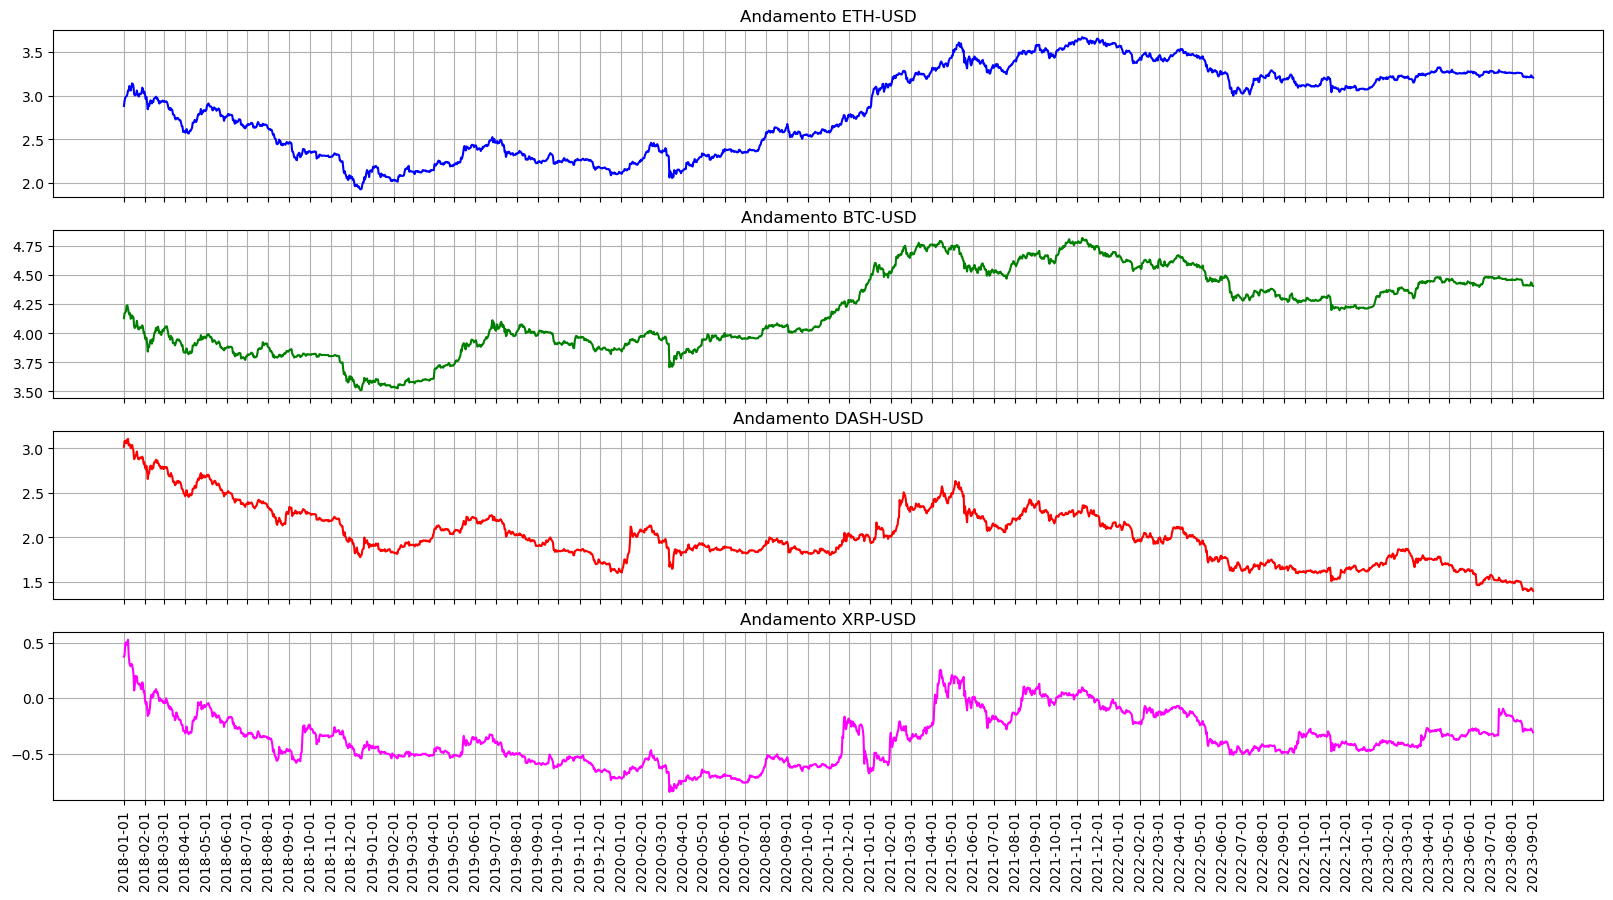

<Figure size 640x480 with 0 Axes>

In [14]:
colors = ["blue", "green", "red", "fuchsia"]
figure, axs = plt.subplots(nrows = len(cryptoList), sharex = True, figsize = (20,10))

xtickPoints = cryptoDataFrameDict["ETH-USD"]["Date"]
xtickPoints = xtickPoints[xtickPoints.str.endswith("01") == 1]
i = 0 
for crypto in cryptoList :
    axs[i].plot(cryptoDataFrameDict[crypto]["LogClosePrice"], color = colors[i % len(colors)])
    axs[i].set_title("Andamento " + crypto)
    axs[i].grid(True)
    i += 1

axs[len(cryptoList) - 1].set_xticks(xtickPoints.index)
axs[len(cryptoList) - 1].set_xticklabels(xtickPoints.values, rotation = 90)

plt.show()
plt.clf()

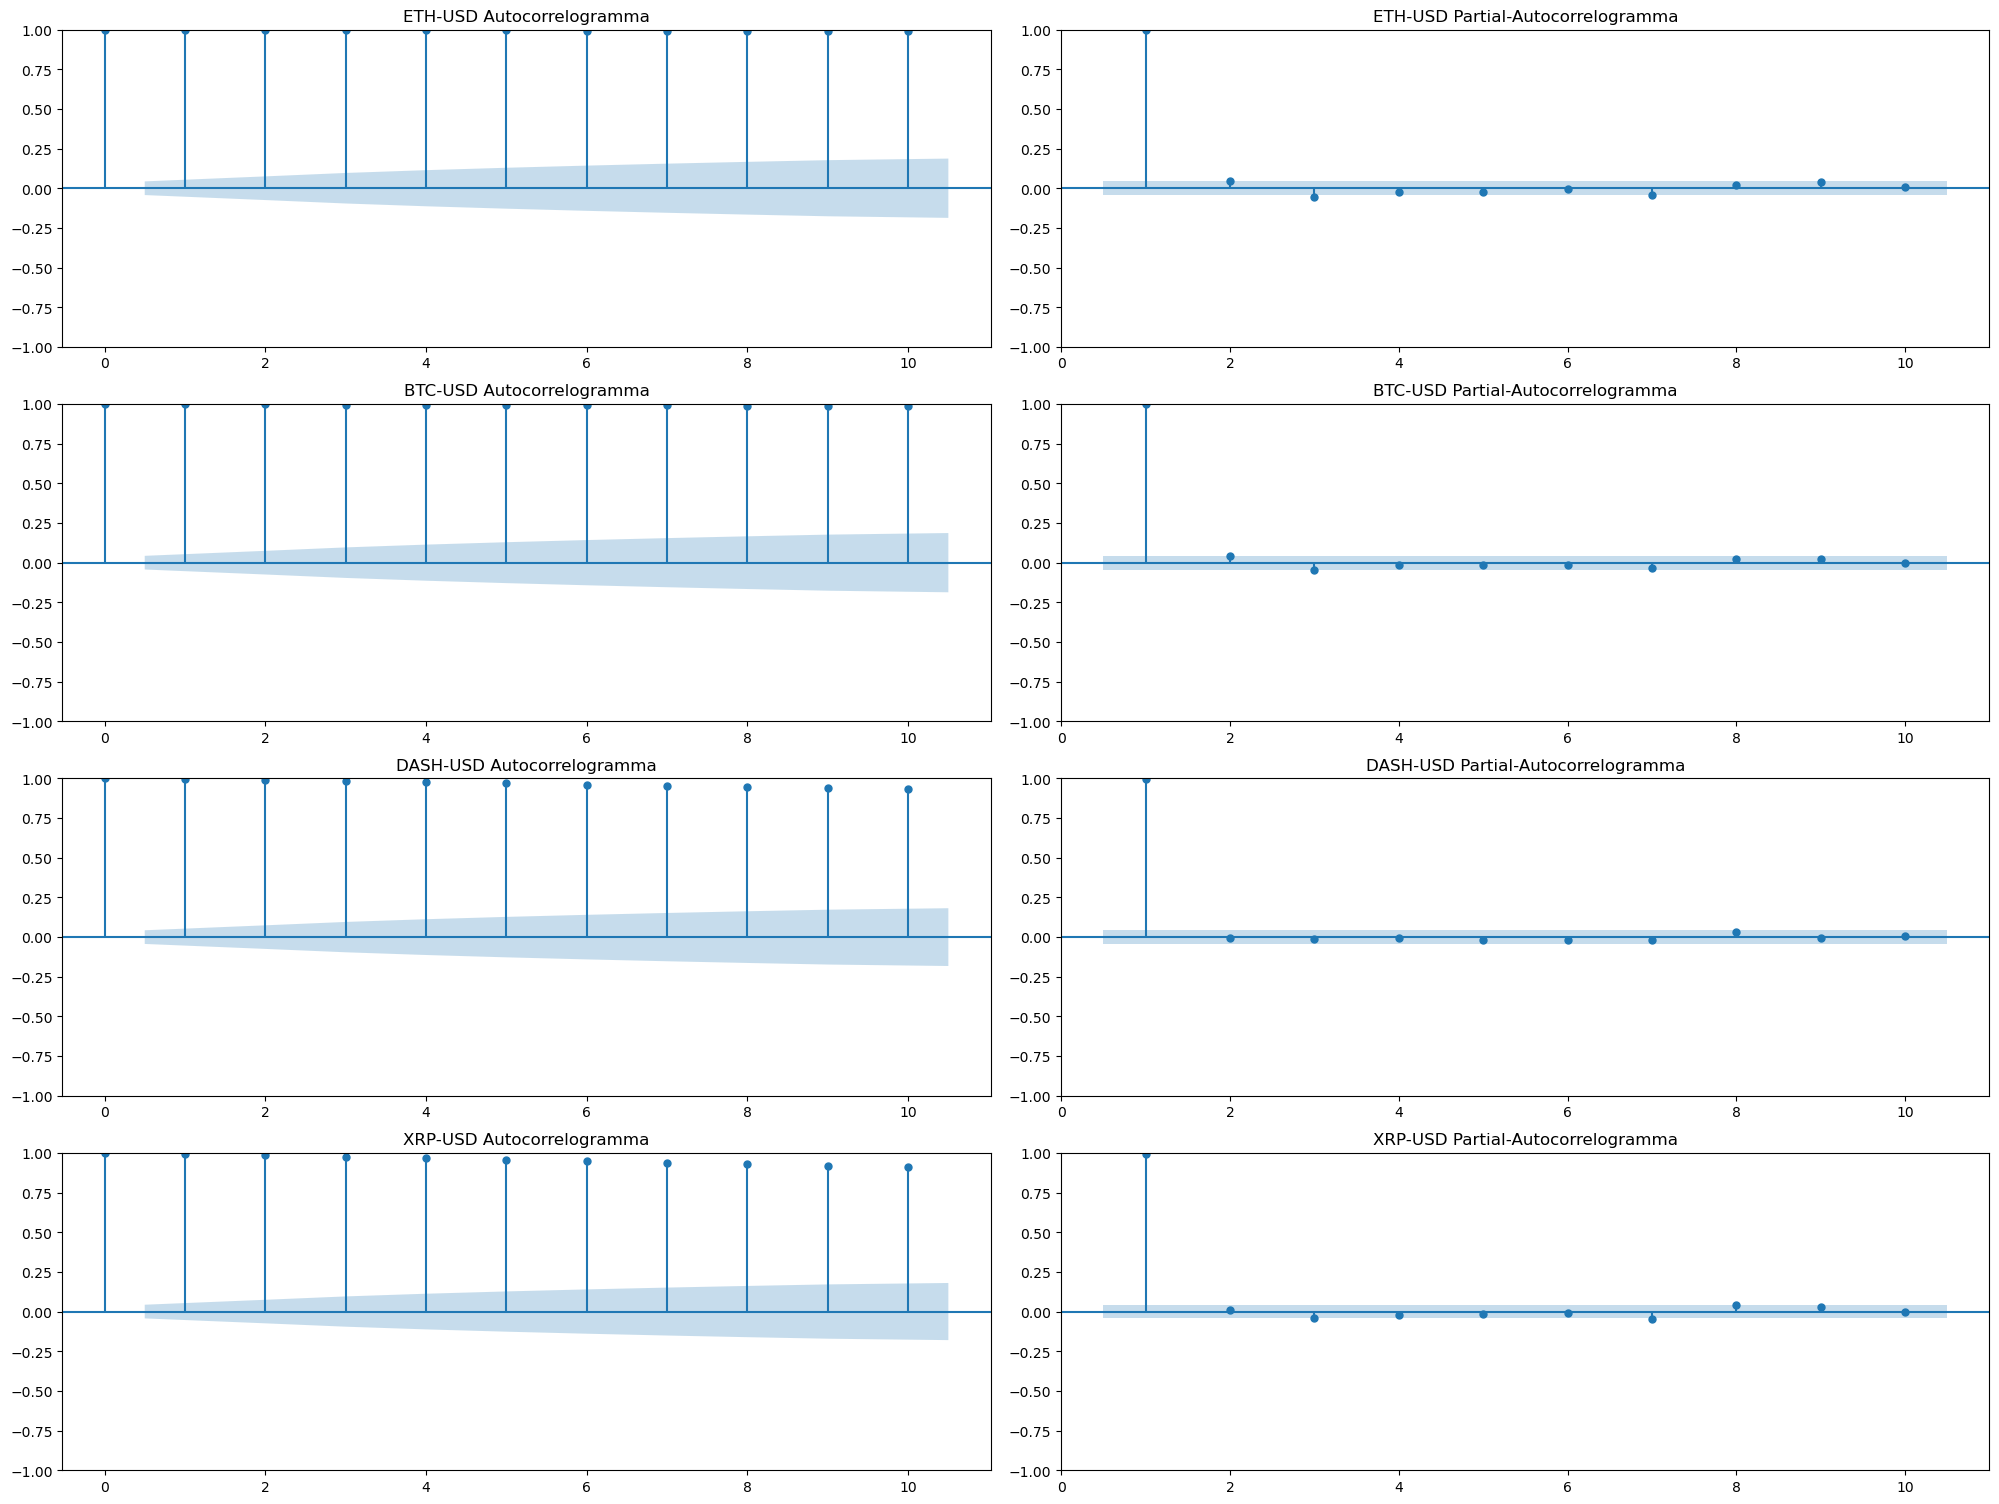

<Figure size 640x480 with 0 Axes>

In [15]:
correlograms(cryptoDataFrameDict, "LogClosePrice", cryptoList, "Autocorrelogramma", "Partial-Autocorrelogramma", zeroPar = False)

### 2_2. Ricerca di una componenti di Random Walk
Le componenti di Random Walk vengono ricercate usando due Test di Ipotesi:
* ADF
* KPSS

Nel test di KPSS abbiamo:
* $H_0$ : La serie è stazionaria attorno a una tendenza deterministica (NON ha componente di Random Walk)
* $H_1$ : La serie non è stazionaria (HA componente di Random Walk)

Nel test di ADF abbiamo:
* $H_0$ : La serie ha una radice unitaria (HA componente di Random Walk)
* $H_1$ : La serie non ha una radice unitaria (NON ha componente di Random Walk)

Nel nostro caso vogliamo:
* KPSS, **Rigettare**
* ADF, **Accettare**

In [16]:
kpss_test(cryptoDataFrameDict, "LogClosePrice", cryptoList)
adf_test(cryptoDataFrameDict, "LogClosePrice", cryptoList)

## TODO print(result)
## Conclusione: Trend stocastico presente ma abbastanza debole (per l'ultimo)

                        KPSS                        
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃          StatValue ┃ pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │  4.630432272815153 │   0.01 │ Reject  │
│ BTC-USD  │  4.820559865672976 │   0.01 │ Reject  │
│ DASH-USD │ 2.7531299544913352 │   0.01 │ Reject  │
│ XRP-USD  │  0.918683154822733 │   0.01 │ Reject  │
└──────────┴────────────────────┴────────┴─────────┘

                                ADF                                
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃           StatValue ┃               pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │ -0.9501313424178288 │   0.7710157360162664 │ Accept  │
│ BTC-USD  │  -0.978510604401754 │   0.7610211585021541 │ Accept  │
│ DASH-USD │ -2.8180938650045064 │   0.0557353087206187 │ Accept  │
│ XRP-USD  │  -3.500868599705032 │ 0.007964814582617451 │ Reject  │
└──────────┴─────────────────────┴──────────────────────┴─────────┘

### 2_3. Differencing della serie storica e analisi del rumore
Procediamo lo studio con l'analisi del rumore.

Passiamo al differencing della serie storica, ottenendo $Y_{t+1} - Y_{t} = W_{t}$ e procedendo con un'analisi del termine $W_{t}$.

Il differencing viene fatto sul risultato del passaggio al logaritmo dei valori originari. Siano:
* *Y*, valori logaritmici
* *P*, valori originari
* *R*, rendimento

Fare il differencing dei valori logaritmici ci permette di fare quanto segue:

$Y_{t+1} - Y_{t} = \log(P_{t+1}) - \log(P_t) = \log(\frac{P_{t+1}}{P_{t}}) = \log(R) = W_t$

Ovvero analizzare se il rendimento ha o meno natura di rumore bianco

In [17]:
differencingDict : dict[str, pd.DataFrame] = {}
for crypto in cryptoDataFrameDict :
    logPriceSeries : pd.Series = cryptoDataFrameDict[crypto]["LogClosePrice"]
    differencing : pd.Series = logPriceSeries.diff()
    differencing.dropna(inplace = True)
    differencing.reset_index(inplace = True, drop = True)
    differencingDict[crypto] = pd.DataFrame({"Diff" : differencing.values, "QuadDiff" : (differencing.pow(2)).values})

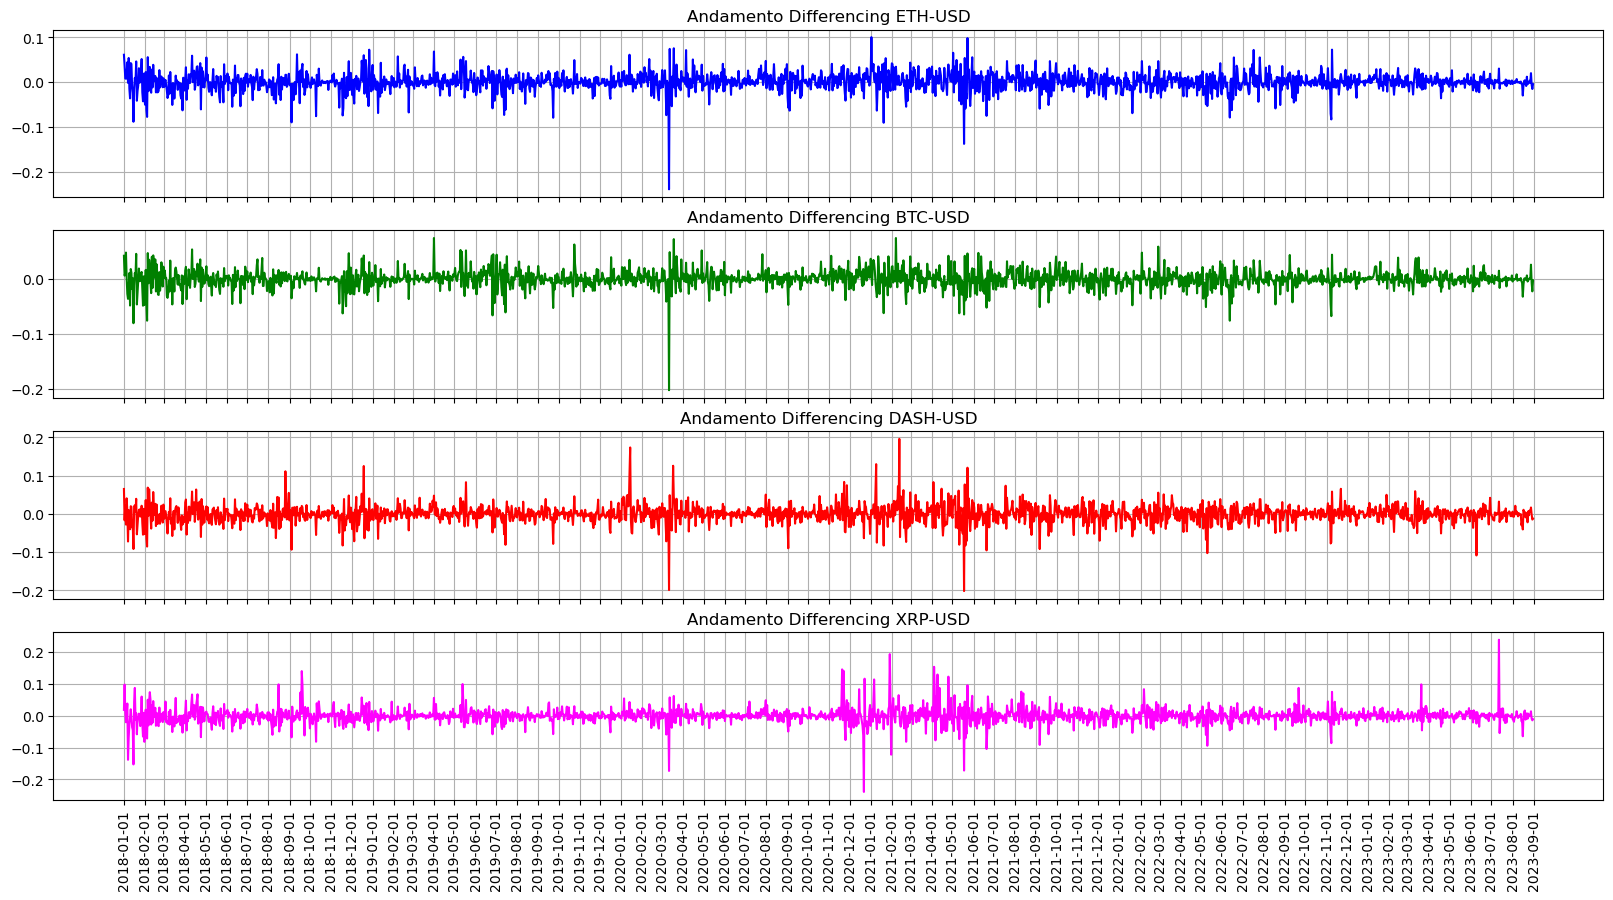

<Figure size 640x480 with 0 Axes>

In [18]:
figure, axs = plt.subplots(nrows = len(cryptoList), sharex = True, figsize = (20,10))

xtickPoints = cryptoDataFrameDict["ETH-USD"]["Date"]
xtickPoints = xtickPoints[xtickPoints.str.endswith("01") == 1]
i = 0 
for crypto in cryptoList :
    axs[i].plot(differencingDict[crypto]["Diff"], color = colors[i % len(colors)])
    axs[i].set_title("Andamento Differencing " + crypto)
    axs[i].grid(True)
    i += 1

axs[len(cryptoList) - 1].set_xticks(xtickPoints.index)
axs[len(cryptoList) - 1].set_xticklabels(xtickPoints.values, rotation = 90)

plt.show()
plt.clf()

#### 2_3_1. Analisi Stazionarietà
Per l'analisi di stazionarietà eseguiamo due test:
* KDSS
* Adfuller

Nel test di KPSS abbiamo:
* *H0* : La serie è stazionaria attorno a una tendenza deterministica
* *H1* : La serie non è stazionaria

Nel test di Adfuller abbiamo:
* *H0* : La serie ha una radice unitaria
* *H1* : La serie non ha una radice unitaria

Nel nostro caso vogliamo:
* KPSS, **Accettare**
* Adfuller, **Rigettare**

In [19]:
kpss_test(differencingDict, "Diff", cryptoList)
adf_test(differencingDict, "Diff", cryptoList)

                        KPSS                         
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃           StatValue ┃ pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │ 0.23201574524870314 │    0.1 │ Accept  │
│ BTC-USD  │ 0.15674142996559834 │    0.1 │ Accept  │
│ DASH-USD │ 0.13769918829263092 │    0.1 │ Accept  │
│ XRP-USD  │ 0.19808342863898767 │    0.1 │ Accept  │
└──────────┴─────────────────────┴────────┴─────────┘

                                 ADF                                 
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃           StatValue ┃                 pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │ -13.748813873133498 │ 1.0600349812346284e-25 │ Reject  │
│ BTC-USD  │ -31.470467916876196 │                    0.0 │ Reject  │
│ DASH-USD │ -21.645263875919735 │                    0.0 │ Reject  │
│ XRP-USD  │  -46.79501030099321 │                    0.0 │ Reject  │
└──────────┴─────────────────────┴────────────────────────┴─────────┘

Dal test di KPSS e dal test ADF, possiamo concludere che il differencing $W_t$ è stazionario

#### 2_3_2. Analisi Eteroschedasticità
Per l'analisi di eteroschedasticità eseguiamo i seguenti test:
* Breusch-Pagan
* White

Nel test di Breusch-Pagan abbiamo:
* $H_0$: I residui sono distribuiti con varianza omogenea (La serie è Omoschedastica)
* $H_1$: I residui *NON* sono distribuiti con varianza omogenea (La serie *NON* è omoschedastica)

Nel test di White abbiamo:
* $H_0$: La varianza dei residui è costante (La serie è Omoschedastica)
* $H_1$: La varianza dei residui *NON* è costante (La serie *NON* è Omoschedastica)

In questo caso vogliamo:
* Breusch-Pagan, **Accettare**
* White, **Accettare**

In [20]:
breusch_pagan_test(differencingDict, "Diff", cryptoList, printSummary = True)
white_test(differencingDict, "Diff", cryptoList)

ETH-USD
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5481
Date:                Tue, 05 Dec 2023   Prob (F-statistic):              0.459
Time:                        11:25:41   Log-Likelihood:                 5049.8
No. Observations:                2069   AIC:                        -1.010e+04
Df Residuals:                    2067   BIC:                        -1.008e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.001     -0.472      0.637      -0.002       0.001
x1          5.746e-07   7.76e-07      0.740      0.459   -9.47e-07     2.1e-06
==============================================================================
Omnibus:                      632.947   Durbin-Watson:                   2.106
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10358.413
Skew:                          -0.995   Prob(JB):                         0.00
Kurtosis:                      13.779   Cond. No.                     2.39e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.39e+03. This might indicate that there are
strong multicollinearity or other numerical problems.

BTC-USD
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1443
Date:                Tue, 05 Dec 2023   Prob (F-statistic):              0.704
Time:                        11:25:41   Log-Likelihood:                 5578.7
No. Observations:                2069   AIC:                        -1.115e+04
Df Residuals:                    2067   BIC:                        -1.114e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.001     -0.143      0.887      -0.002       0.001
x1          2.283e-07   6.01e-07      0.380      0.704    -9.5e-07    1.41e-06
==============================================================================
Omnibus:                      697.962   Durbin-Watson:                   2.089
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16730.990
Skew:                          -1.029   Prob(JB):                         0.00
Kurtosis:                      16.778   Cond. No.                     2.39e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.39e+03. This might indicate that there are
strong multicollinearity or other numerical problems.

DASH-USD
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.3637
Date:                Tue, 05 Dec 2023   Prob (F-statistic):              0.547
Time:                        11:25:41   Log-Likelihood:                 4747.7
No. Observations:                2069   AIC:                            -9491.
Df Residuals:                    2067   BIC:                            -9480.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.001     -1.252      0.211      -0.003       0.001
x1          5.417e-07   8.98e-07      0.603      0.547   -1.22e-06     2.3e-06
==============================================================================
Omnibus:                      376.450   Durbin-Watson:                   2.095
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8823.543
Skew:                          -0.083   Prob(JB):                         0.00
Kurtosis:                      13.116   Cond. No.                     2.39e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.39e+03. This might indicate that there are
strong multicollinearity or other numerical problems.

XRP-USD
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.386
Date:                Tue, 05 Dec 2023   Prob (F-statistic):              0.239
Time:                        11:25:41   Log-Likelihood:                 4673.8
No. Observations:                2069   AIC:                            -9344.
Df Residuals:                    2067   BIC:                            -9332.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.001     -1.315      0.189      -0.004       0.001
x1          1.096e-06   9.31e-07      1.177      0.239    -7.3e-07    2.92e-06
==============================================================================
Omnibus:                      510.216   Durbin-Watson:                   2.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22254.586
Skew:                           0.337   Prob(JB):                         0.00
Kurtosis:                      19.053   Cond. No.                     2.39e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.39e+03. This might indicate that there are
strong multicollinearity or other numerical problems.

                           Breusch-Pagan                           
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃          StatValue ┃                pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │  8.567367566736669 │ 0.0034597918568196914 │ Reject  │
│ BTC-USD  │  7.763759935805086 │  0.005379165131515243 │ Reject  │
│ DASH-USD │  2.276765009171112 │    0.1314783730532143 │ Accept  │
│ XRP-USD  │ 1.2467607341644058 │    0.2643018406639988 │ Accept  │
└──────────┴────────────────────┴───────────────────────┴─────────┘

                              White                               
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃          StatValue ┃               pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │   5.26508181913567 │ 0.005238555530471663 │ Reject  │
│ BTC-USD  │  4.141400487811925 │ 0.016032762971599328 │ Reject  │
│ DASH-USD │  3.666072606577798 │ 0.025743255972081297 │ Reject  │
│ XRP-USD  │ 0.7598677076192619 │   0.4678589731665155 │ Accept  │
└──────────┴────────────────────┴──────────────────────┴─────────┘

#### 2_3_3. Analisi Autocorrelazione

Per l'Autocorrelazione consideriamo i seguenti test:
* Ljung-Box

Per il test Ljung-Box:
* $H_0$: Non c'è autocorrelazione nei dati. In altre parole, i residui sono indipendenti l'uno dall'altro e non mostrano alcuna struttura di autocorrelazione significativa.
* $H_1$: I residui non sono indipendenti e mostrano una struttura di autocorrelazione significativa.

Vogliamo quindi :
* Ljung-Box, **Accettare**

In [21]:
ljung_box_test(differencingDict, "Diff", cryptoList)

                             Ljung-Box                             
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃          StatValue ┃                pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │ 31.609722534078987 │ 0.0004650065716092994 │ Reject  │
│ BTC-USD  │ 16.925034452734113 │   0.07603932218108504 │ Accept  │
│ DASH-USD │ 15.716773963771859 │   0.10803220218423684 │ Accept  │
│ XRP-USD  │  7.977674132723926 │     0.631017790629593 │ Accept  │
└──────────┴────────────────────┴───────────────────────┴─────────┘

Tracciamo gli autocorrelogrammi e gli autocorrelogrammi parziali dei dati.

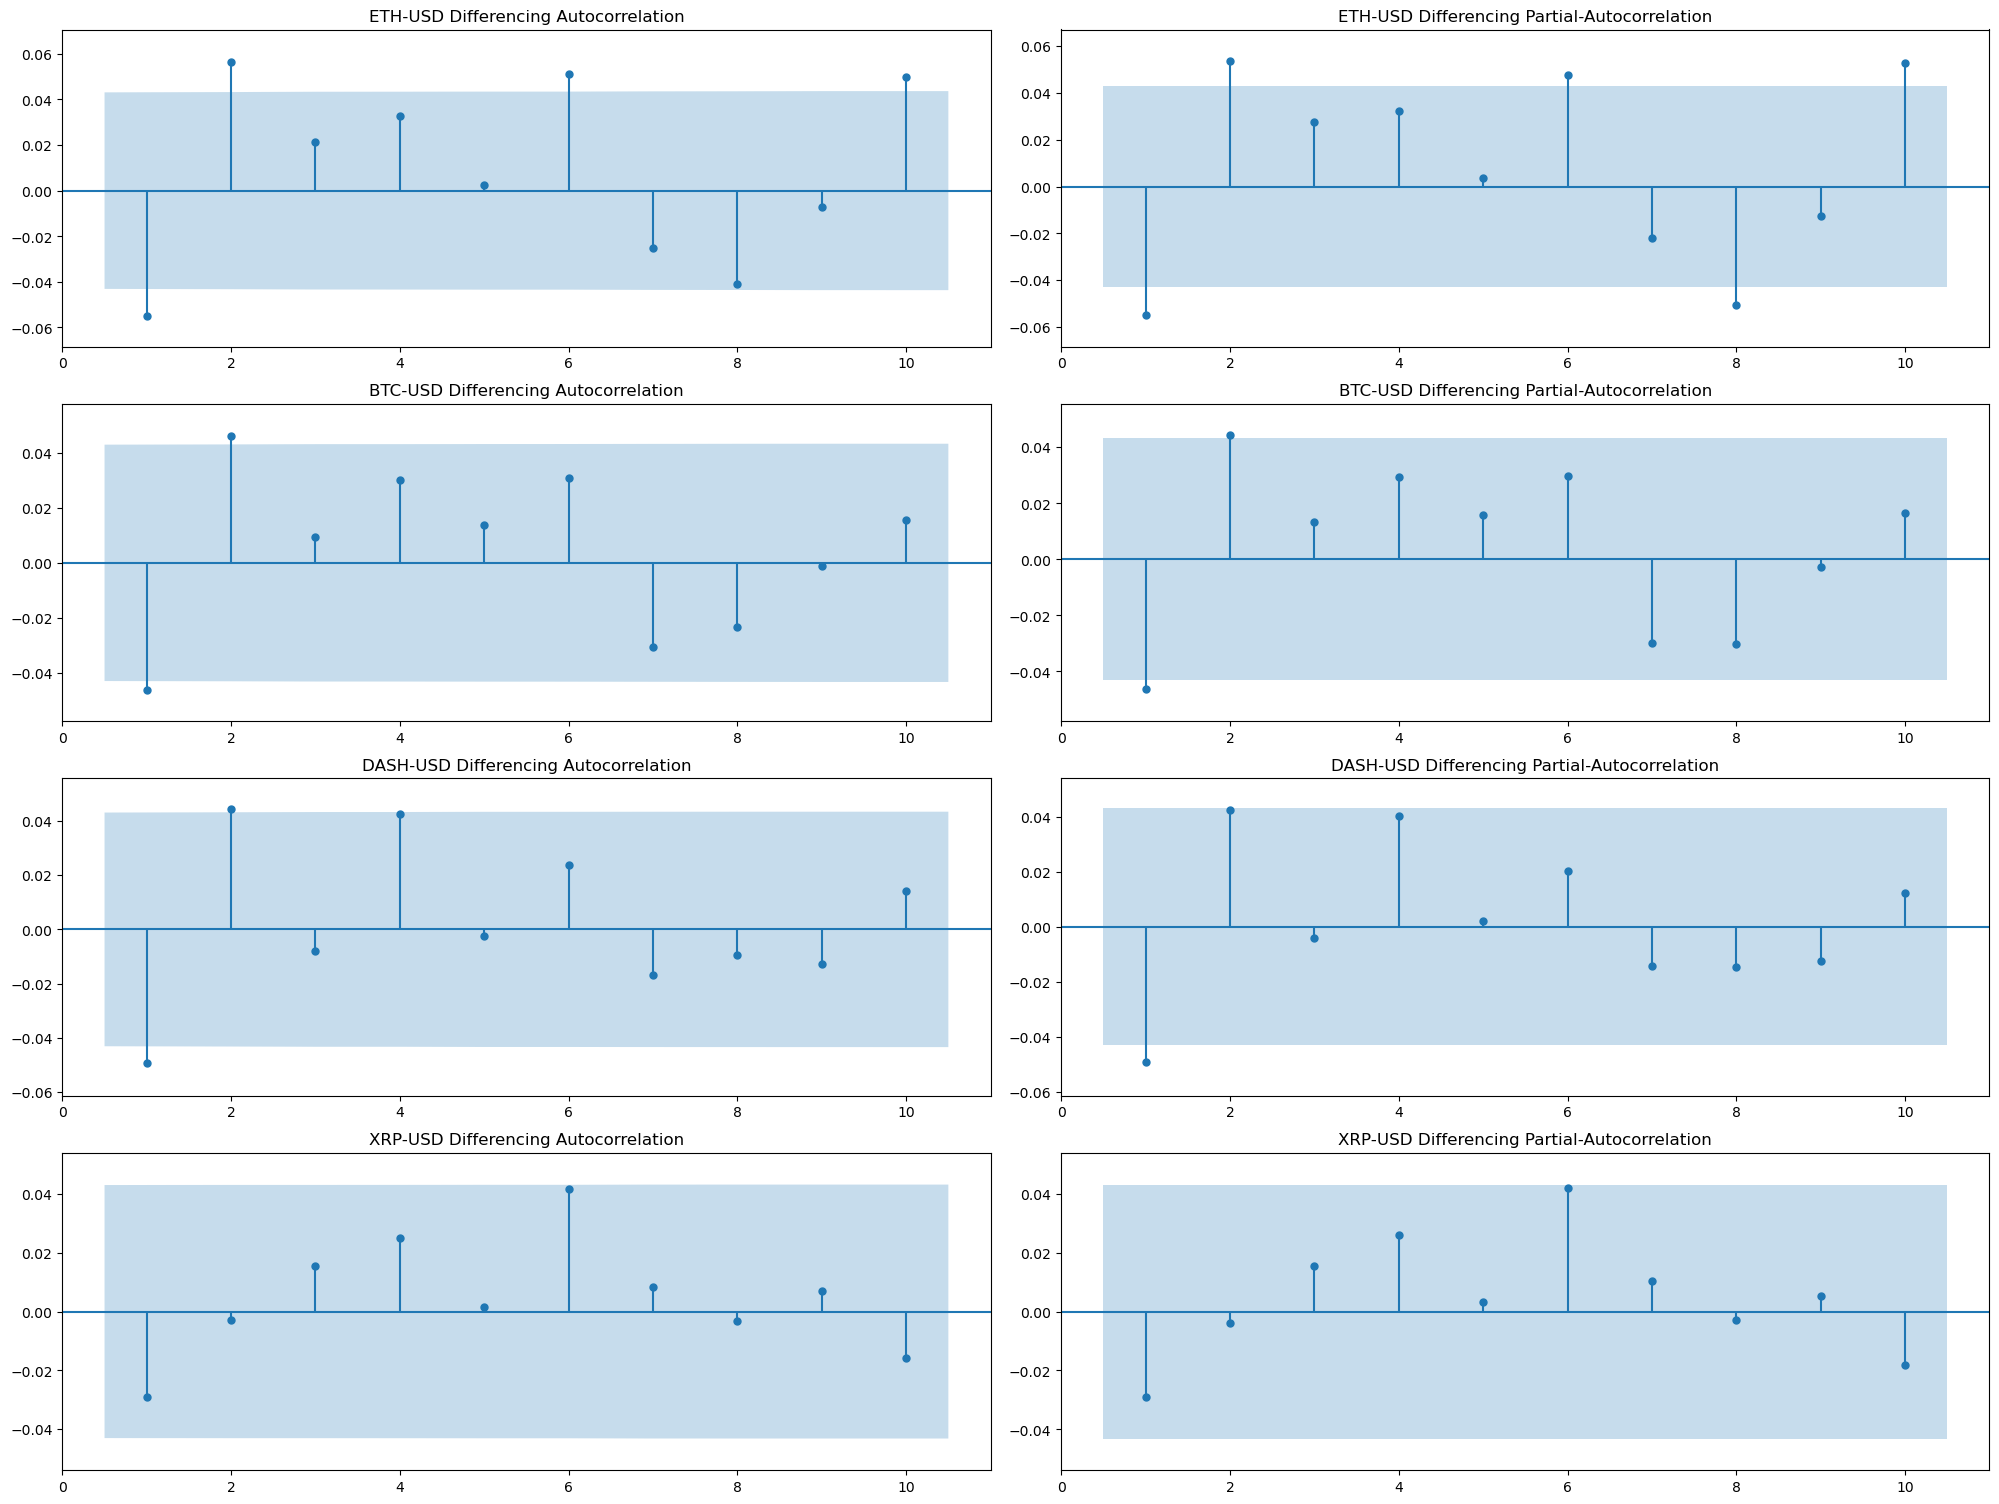

<Figure size 640x480 with 0 Axes>

In [22]:
correlograms(differencingDict, "Diff", cryptoList, titleAuto = "Differencing Autocorrelation", titlePartial = "Differencing Partial-Autocorrelation", zeroAuto = False, yLimsAuto = True, zeroPar = False, yLimsPar = True)

Il test quindi Accetta per entrambi i casi e i dati non dovrebbero essere autocorrelati.
Tuttavia, osservando i grafici relativi al differencing, possiamo notare come vi siano dei cluster di varianza costante, in cui a basse varianze seguono zone di bassa varianza (analogamente per quelle ad alta varianza).

Riassumendo abbiamo:
* Accettazione del test di Ljung-Box
* Presenza di clusterizzazione delle varianze
Questo fenomeno potrebbe essere dovuto al fatto che i dati sono molti, e quindi il grande numero di dati potrebbe offuscare l'autocorrelazione portando i dati a tendere al gaussiano.

Ci fa supporre la presenza di punti di rottura nella struttura. 

Passiamo quindi, dopo dei veloci test sulla gaussianità, all'analisi delle rotture strutturali.

#### 2_3_4. Analisi Normalità
Per l'analisi di normalità eseguiamo i seguenti test:
* Shapiro-Wilk
* Kolmogorov-Smirnov

Nel test di Shapiro-Wilk abbiamo:
* $H_0$: I dati seguono una distribuzione normale
* $H_1$: I dati NON seguono una distribuzione normale

Nel test di Kolmogorov-Smirnov abbiamo:
* $H_0$: I dati seguono la distribuzione specificata
* $H_1$: I dati NON seguono la distribuzione specificata

Nel nostro caso vogliamo:
* Shapiro-Wilk, **Accettare**
* Kolmogorov-Smirnov, **Accettare**

In [23]:
shapiro_wilk(differencingDict, "Diff", cryptoList)
kolmogorov_smirnov(differencingDict, "Diff", cryptoList)

                            Shapiro-Wilk                            
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃          StatValue ┃                 pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │ 0.9225029349327087 │  2.243272511905845e-31 │ Reject  │
│ BTC-USD  │ 0.9065624475479126 │  7.687562699532387e-34 │ Reject  │
│ DASH-USD │ 0.9040272235870361 │ 3.3494620980164206e-34 │ Reject  │
│ XRP-USD  │ 0.8357081413269043 │   7.15923385423549e-42 │ Reject  │
└──────────┴────────────────────┴────────────────────────┴─────────┘

                 Kolmogorov-Smirnov                  
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃           StatValue ┃ pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │  0.4705378122861261 │    0.0 │ Reject  │
│ BTC-USD  │ 0.47608764853183083 │    0.0 │ Reject  │
│ DASH-USD │ 0.46608875744466827 │    0.0 │ Reject  │
│ XRP-USD  │  0.4642030732172747 │    0.0 │ Reject  │
└──────────┴─────────────────────┴────────┴─────────┘

Notiamo quindi che i due test ci fanno rigettare in entrambi i casi l'ipotesi nulla di normalità dei dati.
Per completezza tracciamo un grafico dei dati.

In [91]:
#TODO media nulla -> interessante (indice di mercato efficiente) (BTC prof)
# Ipotesi nulla: la media è zero
null_hypothesis_mean = 0
alpha = 0.05
meanTable = buildTable("Zero Mean Test", ["Crypto", "T-Statistic", "P-Value", "Result"], ["left", "right", "right", "left"])
for crypto in cryptoList:
    # Esegue il test t
    t_statistic, p_value = ttest_1samp(differencingDict[crypto]["Diff"], null_hypothesis_mean)


    # Confronta il p-value con un livello di significatività predefinito (ad esempio, 0.05)
    outcomeString = "Reject" if p_value < alpha else "Accept"
    meanTable.add_row(crypto, str(t_statistic), str(p_value), outcomeString)
# Stampa i risultati del test
console = Console()
console.print(meanTable)

                         Zero Mean Test                          
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Crypto   ┃         T-Statistic ┃             P-Value ┃ Result ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ ETH-USD  │ 0.33808066325759595 │  0.7353367184851297 │ Accept │
│ BTC-USD  │  0.3725821323911949 │  0.7094976528285228 │ Accept │
│ DASH-USD │  -1.459006273766798 │ 0.14471524793122822 │ Accept │
│ XRP-USD  │ -0.5918757465602607 │  0.5539984936921993 │ Accept │
└──────────┴─────────────────────┴─────────────────────┴────────┘

### 2_4. Analisi dei Punti di Rottura nella Struttura
Cerchiamo i punti di rottura usando la funzione *breakpoints* del package *strucchange* di R.

In [24]:
# Loading the function we have defined in R.
r['source']('./R/R_Scripts.R')

breakPointSearch_R = robjects.globalenv['breakPointSearch']
fstatBreakpointsSearch_R = robjects.globalenv['fstatBreakpointsSearch']
supmzBreakpointsSearch_R = robjects.globalenv['supmzBreakpointsSearch']

cryptoBreakPointsDict_1 = {}
cryptoBreakPointsDict_2 = {}
cryptoBreakPointsDict_3 = {}

for crypto in cryptoList :
    ## Converting to R dataFrame
    closePrice_R = pandas2ri.py2rpy(cryptoDataFrameDict[crypto]["LogClosePrice"])

    # Invoking R function
    breakPointsList_R = breakPointSearch_R(closePrice_R)

    #Converting it back to a pandas dataframe.
    breakPointsList = np.array(breakPointsList_R)

    breakPointsList = [int(elem - 1) for elem in breakPointsList]
    cryptoBreakPointsDict_1[crypto] = breakPointsList

    fstatPointsList_R = fstatBreakpointsSearch_R(closePrice_R)
    fstatBreakPointsList = np.array(fstatPointsList_R)
    fstatBreakPointsList = [int(elem - 1) for elem in fstatBreakPointsList]
    cryptoBreakPointsDict_2[crypto] = fstatBreakPointsList

    logClosePriceDataFrame = pd.DataFrame(cryptoDataFrameDict[crypto]["LogClosePrice"], columns = ["LogClosePrice"])
    logClosePriceDF_R = pandas2ri.py2rpy(logClosePriceDataFrame)
    supmzPointsList_R = supmzBreakpointsSearch_R(logClosePriceDF_R)
    supmzBreakPointsList = list(supmzPointsList_R)
    cryptoBreakPointsDict_3[crypto] = supmzBreakPointsList

In [25]:
breakPointsTable = buildTable("Structural Breakpoints", ["Crypto", "Breakpoint", "FStats", "SupMZ"], ["left", "right", "right", "right"])
for crypto in cryptoList :
    datesString_1 = "| "
    datesString_2 = "| "
    datesString_3 = "| "
    for breakpoint in cryptoBreakPointsDict_1[crypto] :
        date = cryptoDataFrameDict[crypto]["Date"].loc[breakpoint]
        datesString_1 += date + " | "
    for breakpoint in cryptoBreakPointsDict_2[crypto] :
        date = cryptoDataFrameDict[crypto]["Date"].loc[breakpoint]
        datesString_2 += date + " | "
    for breakpoint in cryptoBreakPointsDict_3[crypto] :
        date = cryptoDataFrameDict[crypto]["Date"].loc[breakpoint]
        datesString_3 += date + " | "
    breakPointsTable.add_row(crypto, datesString_1, datesString_2, datesString_3)

console = Console()
console.print(breakPointsTable)

                                         Structural Breakpoints                                          
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Crypto   ┃                                             Breakpoint ┃          FStats ┃           SupMZ ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ ETH-USD  │  | 2018-11-06 | 2020-02-06 | 2021-01-02 | 2022-05-10 | │  | 2020-12-29 | │  | 2021-01-04 | │
│ BTC-USD  │               | 2019-05-12 | 2020-12-15 | 2022-05-08 | │  | 2020-11-11 | │  | 2020-11-06 | │
│ DASH-USD │  | 2018-11-06 | 2019-09-22 | 2021-01-09 | 2022-05-04 | │  | 2018-11-07 | │  | 2022-05-12 | │
│ XRP-USD  │  | 2018-11-18 | 2019-09-24 | 2021-02-08 | 2022-04-28 | │  | 2021-02-08 | │  | 2021-02-05 | │
└──────────┴────────────────────────────────────────────────────────┴─────────────────┴─────────────────┘

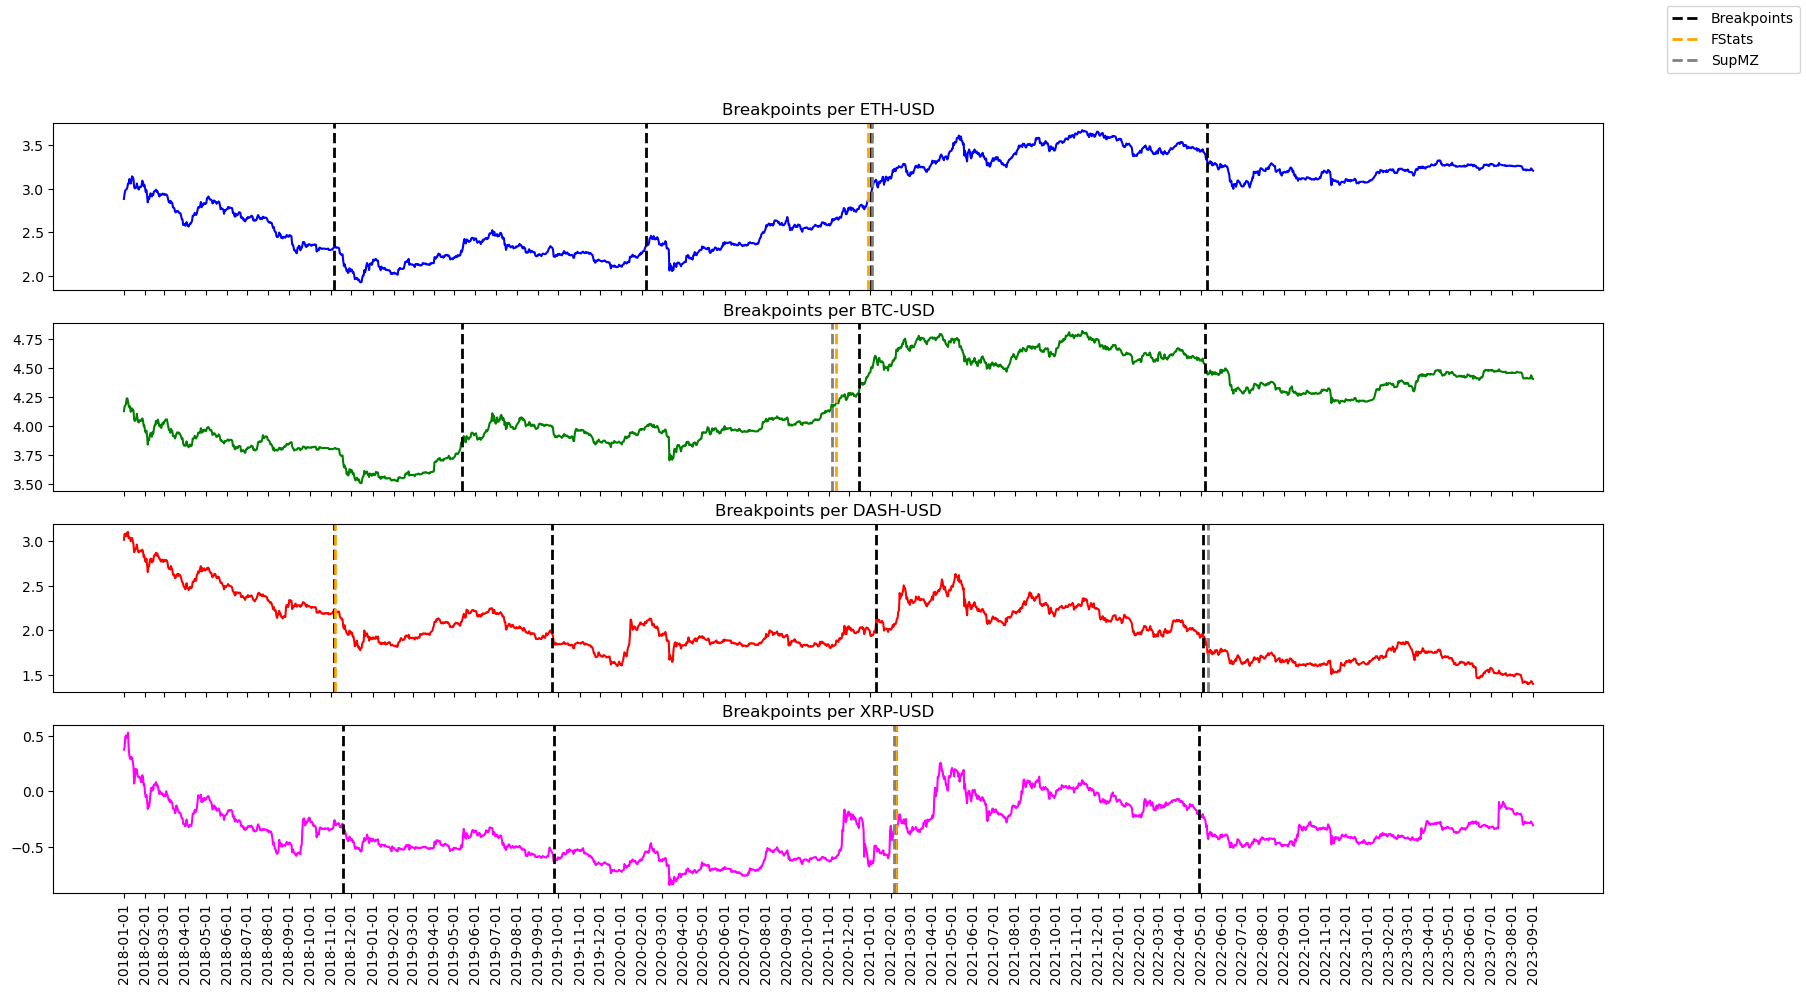

<Figure size 640x480 with 0 Axes>

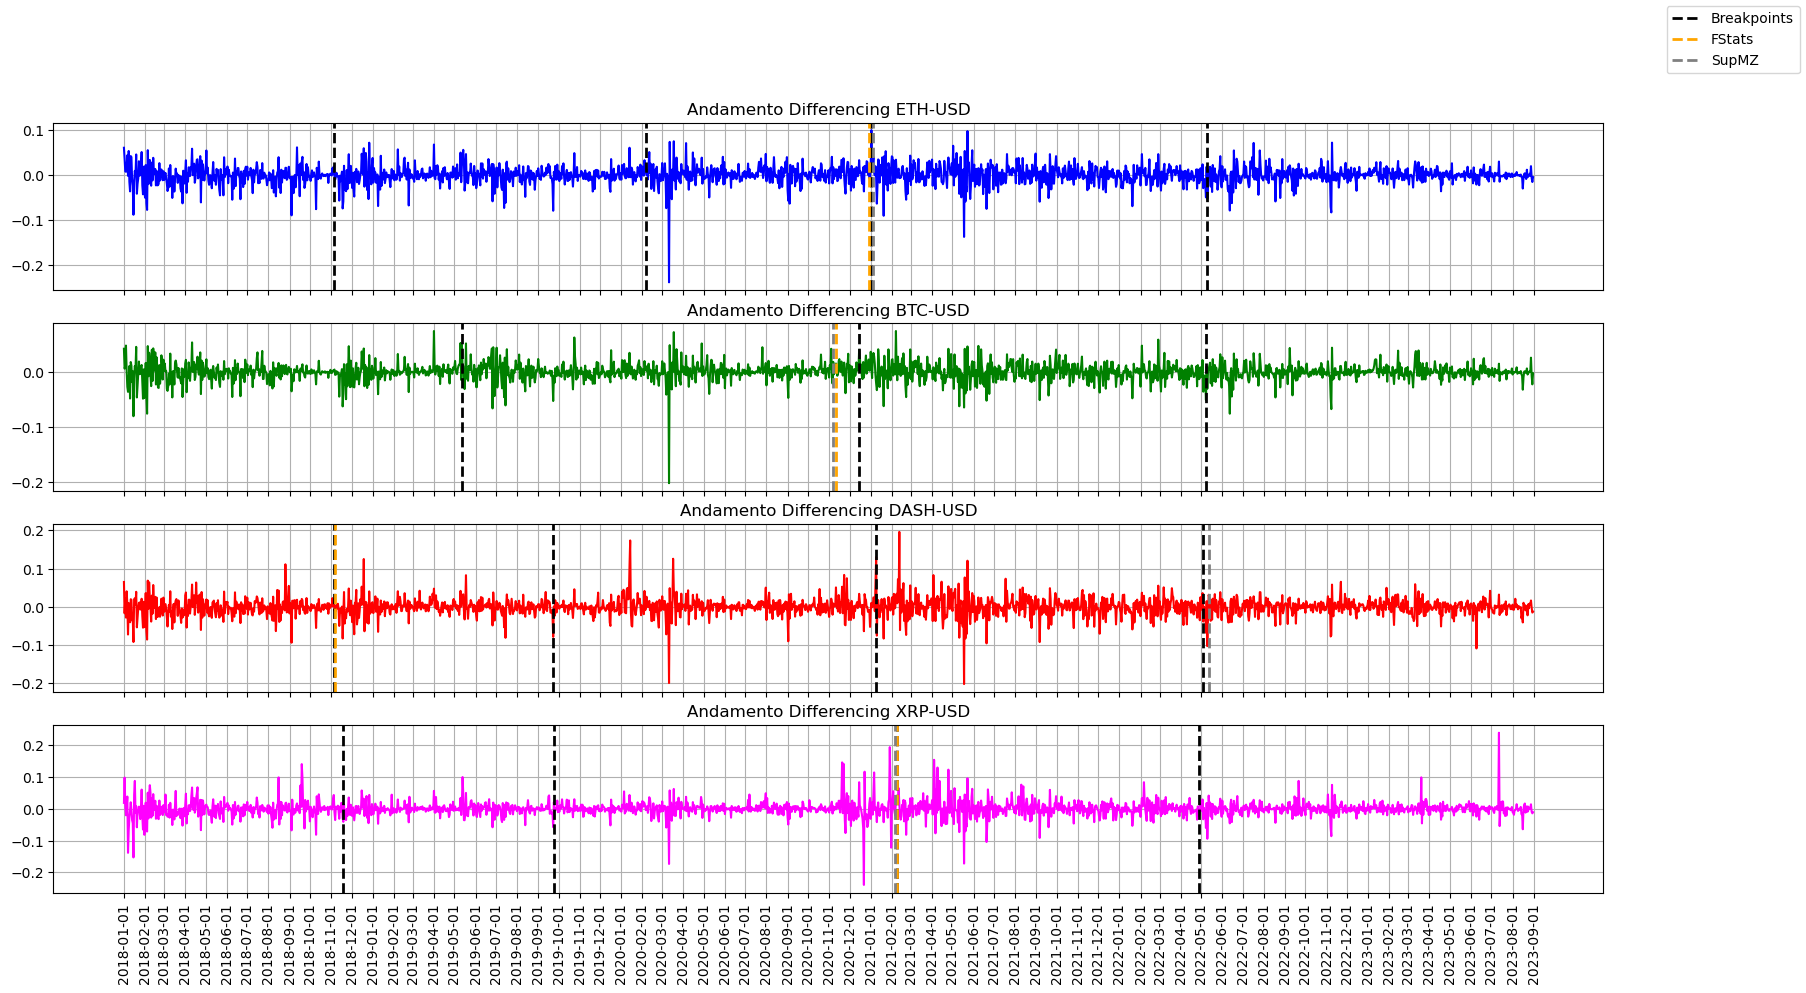

<Figure size 640x480 with 0 Axes>

In [26]:
colors = ["blue", "green", "red", "fuchsia"]

figure, axs = plt.subplots(nrows = len(cryptoList), sharex = True, figsize = (20,10))

xtickPoints = cryptoDataFrameDict["ETH-USD"]["Date"]
xtickPoints = xtickPoints[xtickPoints.str.endswith("01") == 1]
i = 0 
legend_1 = True
legend_2 = True
legend_3 = True
for crypto in cryptoList :
    axs[i].plot(cryptoDataFrameDict[crypto]["LogClosePrice"], color = colors[i % len(colors)])
    axs[i].set_title("Breakpoints per " + crypto)
    # axs[i].grid(True)

    for breakpoint in cryptoBreakPointsDict_1[crypto] :
        axs[i].axvline(x = breakpoint, color = "black", linestyle = "--", linewidth = "2", label = "Breakpoints" if legend_1 else None)
        legend_1 = False
    for breakpoint in cryptoBreakPointsDict_2[crypto] :
        axs[i].axvline(x = breakpoint, color = "orange", linestyle = "--", linewidth = "2", label = "FStats" if legend_2 else None)
        legend_2 = False
    for breakpoint in cryptoBreakPointsDict_3[crypto] :
        axs[i].axvline(x = breakpoint, color = "gray", linestyle = "--", linewidth = "2", label = "SupMZ" if legend_3 else None)
        legend_3 = False
    i += 1
figure.legend()

axs[len(cryptoList) - 1].set_xticks(xtickPoints.index)
axs[len(cryptoList) - 1].set_xticklabels(xtickPoints.values, rotation = 90)

plt.show()
plt.clf()


figure, axs = plt.subplots(nrows = len(cryptoList), sharex = True, figsize = (20,10))

xtickPoints = cryptoDataFrameDict["ETH-USD"]["Date"]
xtickPoints = xtickPoints[xtickPoints.str.endswith("01") == 1]
i = 0
legend_1 = True
legend_2 = True
legend_3 = True
for crypto in cryptoList :
    axs[i].plot(differencingDict[crypto]["Diff"], color = colors[i % len(colors)])
    axs[i].set_title("Andamento Differencing " + crypto)
    axs[i].grid(True)

    for breakpoint in cryptoBreakPointsDict_1[crypto] :
        axs[i].axvline(x = breakpoint, color = "black", linestyle = "--", linewidth = "2", label = "Breakpoints" if legend_1 else None)
        legend_1 = False
    for breakpoint in cryptoBreakPointsDict_2[crypto] :
        axs[i].axvline(x = breakpoint, color = "orange", linestyle = "--", linewidth = "2", label = "FStats" if legend_2 else None)
        legend_2 = False
    for breakpoint in cryptoBreakPointsDict_3[crypto] :
        axs[i].axvline(x = breakpoint, color = "gray", linestyle = "--", linewidth = "2", label = "SupMZ" if legend_3 else None)
        legend_3 = False
        
    i += 1
figure.legend()

axs[len(cryptoList) - 1].set_xticks(xtickPoints.index)
axs[len(cryptoList) - 1].set_xticklabels(xtickPoints.values, rotation = 90)

plt.show()
plt.clf()

I test rilevano quindi la presenza di punti di rottura.

Notiamo in particolare che test diversi rilevano punti di rottura simili: scegliamo quindi di procedere con un "voto a maggioranza", prendendo il punto di rottura più simile tra i tre test.

## 3. Divisione del dataset
Dividiamo il dataset in due parti, training e test set: manteniamo nel training circa il 90% dei dati di ogni strumento

In [27]:
cryptoBreakPointsIndexes = {
    "ETH-USD" : cryptoBreakPointsDict_1["ETH-USD"][2],
    "BTC-USD" : cryptoBreakPointsDict_1["BTC-USD"][1],
    "DASH-USD" : cryptoBreakPointsDict_1["DASH-USD"][3],
    "XRP-USD" : cryptoBreakPointsDict_1["XRP-USD"][2],
}

In [28]:
restrCryptoDataFrameDict : dict[str, pd.DataFrame] = {}
restrDiffDataFrameDict : dict[str, pd.DataFrame] = {}

for crypto in cryptoList :
    breakPoint = cryptoBreakPointsIndexes[crypto]

    restrictedDataFrame : pd.DataFrame = cryptoDataFrameDict[crypto].iloc[cryptoDataFrameDict[crypto].index >= breakPoint]
    restrictedDataFrame.reset_index(drop = True, inplace = True)
    restrCryptoDataFrameDict[crypto] = restrictedDataFrame

    restrictedDiffDataFrame : pd.DataFrame = differencingDict[crypto].iloc[differencingDict[crypto]["Diff"].index >= breakPoint]
    restrictedDiffDataFrame.reset_index(drop = True, inplace = True)
    restrDiffDataFrameDict[crypto] = restrictedDiffDataFrame

In [29]:
trainCryptoDict : dict[str, pd.DataFrame] = {}
testCryptoDict : dict[str, pd.DataFrame] = {}
trainCryptoDiffDict : dict[str, pd.DataFrame] = {}
testCryptoDiffDict : dict[str, pd.DataFrame] = {}

for crypto in cryptoList :
    totalSize = restrCryptoDataFrameDict[crypto].shape[0]
    trainSize = int((totalSize / 100) * 90)
    testSize = totalSize - trainSize

    trainCryptoDict[crypto] = restrCryptoDataFrameDict[crypto].iloc[restrCryptoDataFrameDict[crypto].index < trainSize]
    trainCryptoDict[crypto].reset_index(drop = True, inplace = True)
    testCryptoDict[crypto] = restrCryptoDataFrameDict[crypto].iloc[restrCryptoDataFrameDict[crypto].index >= trainSize]
    testCryptoDict[crypto].reset_index(drop = True, inplace = True)

    trainCryptoDiffDict[crypto] = restrDiffDataFrameDict[crypto].iloc[restrDiffDataFrameDict[crypto].index < trainSize]
    trainCryptoDiffDict[crypto].reset_index(drop = True, inplace = True)
    testCryptoDiffDict[crypto] = restrDiffDataFrameDict[crypto].iloc[restrDiffDataFrameDict[crypto].index >= trainSize]
    testCryptoDiffDict[crypto].reset_index(drop = True, inplace = True)

## 4. Analisi dei dati ristretti

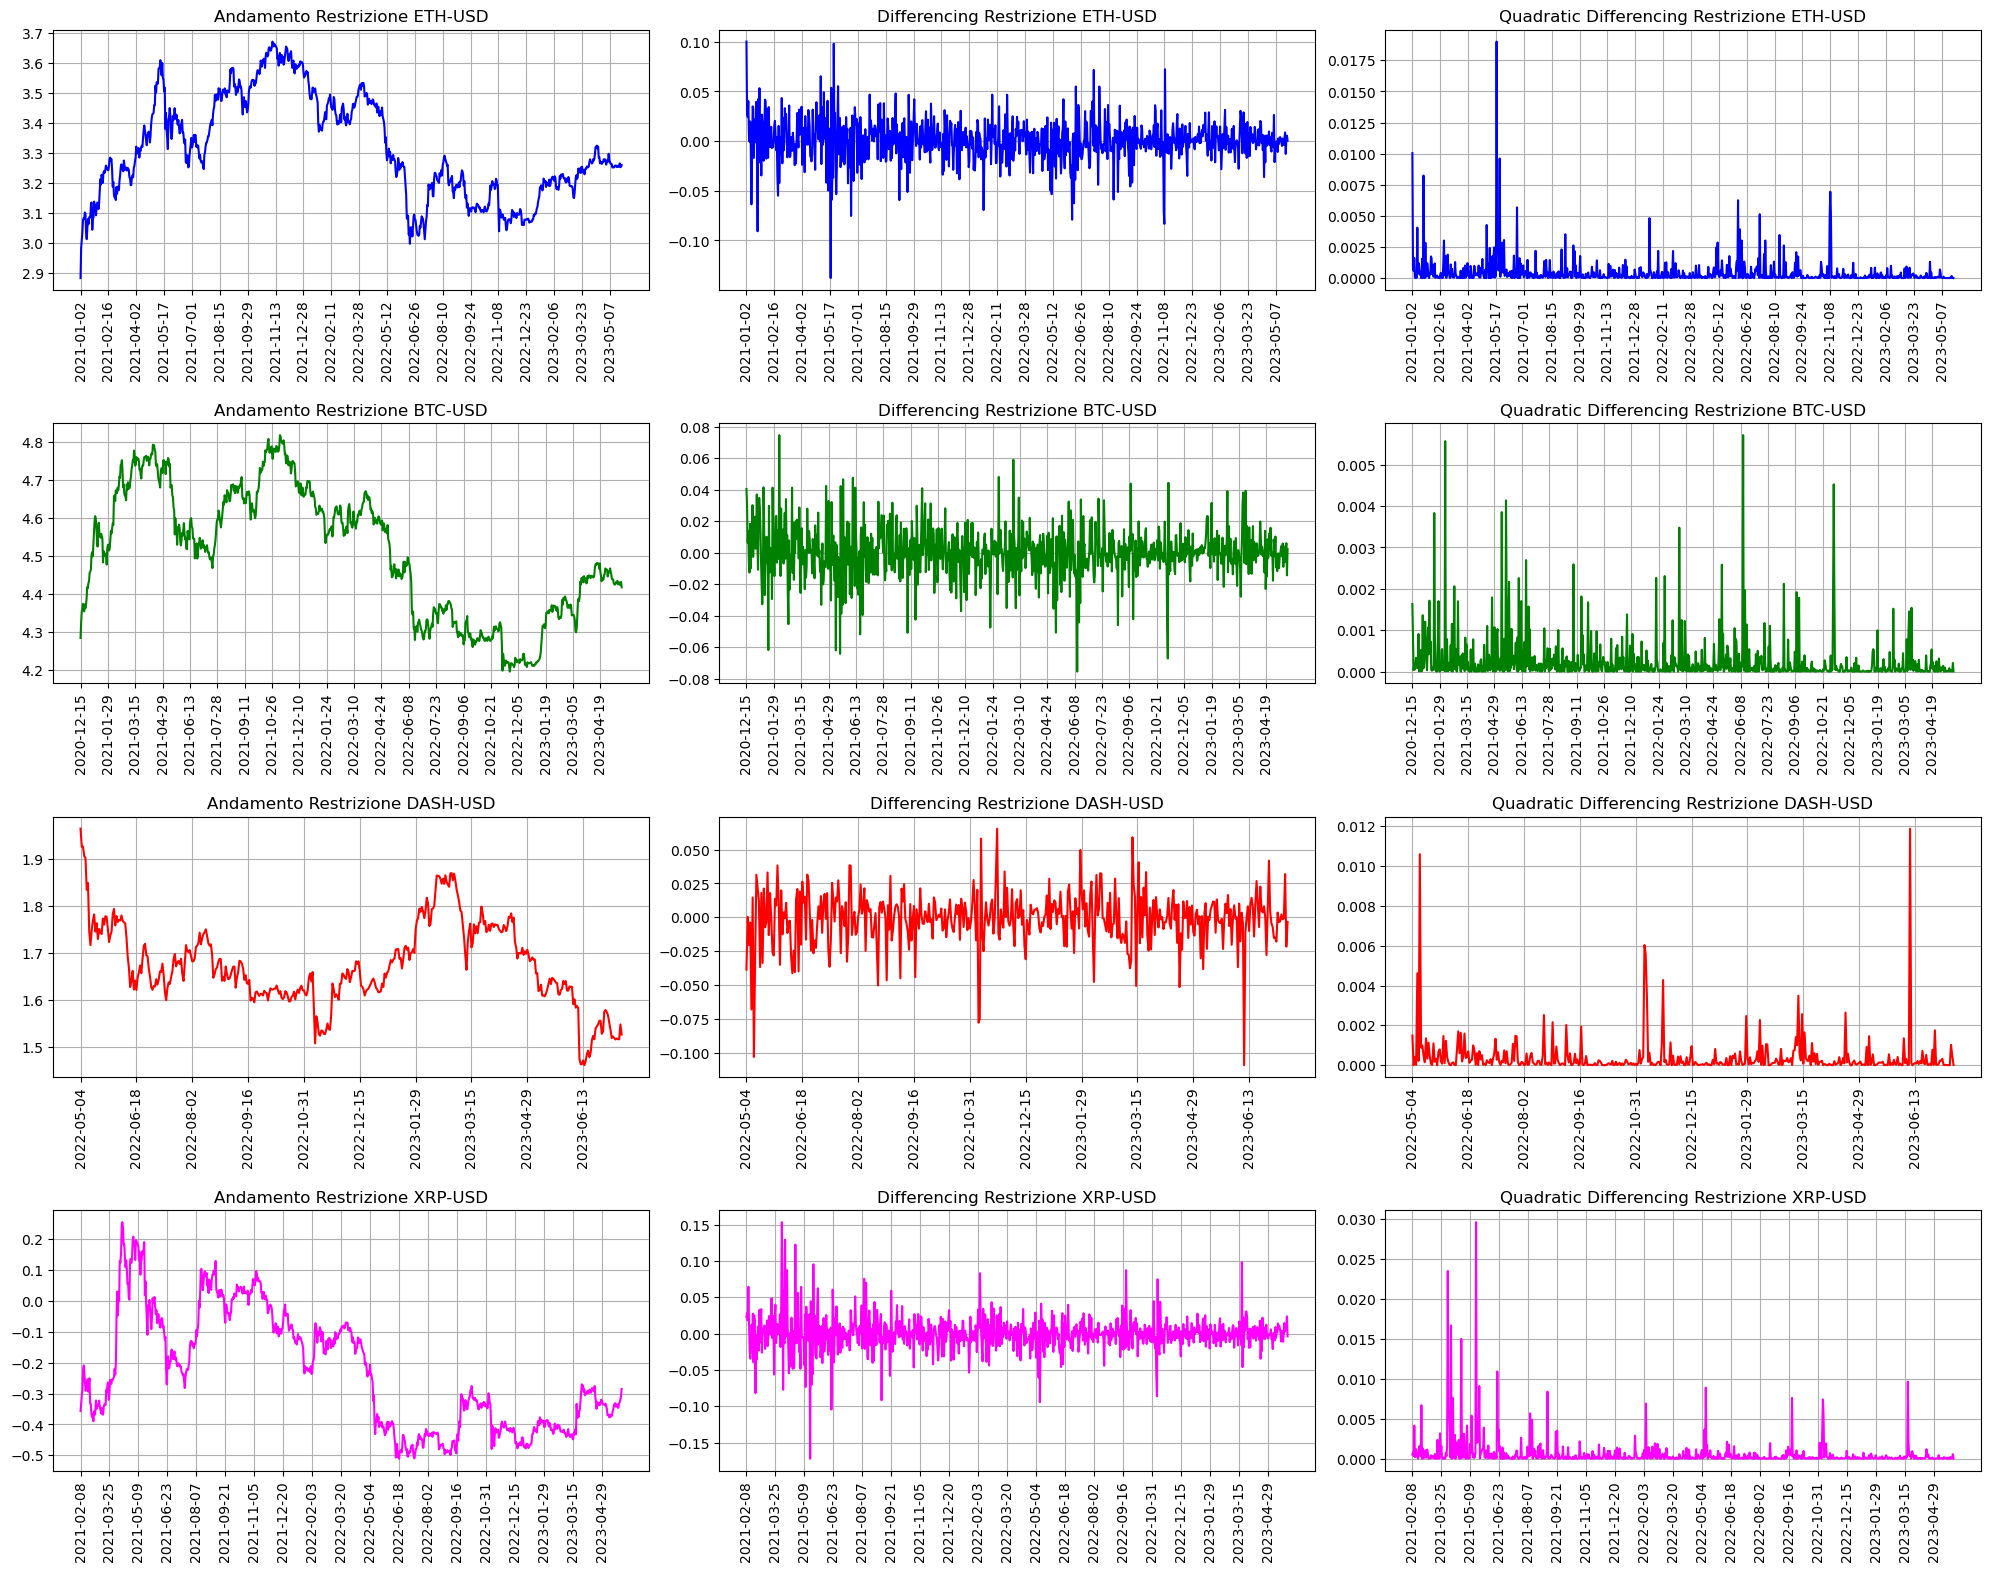

<Figure size 640x480 with 0 Axes>

In [30]:
colors = ["blue", "green", "red", "fuchsia"]
figure, axs = plt.subplots(nrows = len(cryptoList), ncols = 3, figsize = (20,15))
figure.tight_layout(h_pad = 7.5, w_pad = 2)

STEP = 45
ROTATION = 90

i = 0 
for crypto in cryptoList :
    axs[i][0].plot(trainCryptoDict[crypto]["LogClosePrice"], color = colors[i % len(colors)])
    axs[i][0].set_title("Andamento Restrizione " + crypto)
    axs[i][0].grid(True)

    xtickPoints = np.arange(start = 0, stop = trainCryptoDict[crypto].shape[0], step = STEP)
    xtickLabels = trainCryptoDict[crypto]["Date"].iloc[xtickPoints]
    axs[i][0].set_xticks(xtickPoints)
    axs[i][0].set_xticklabels(xtickLabels, rotation = ROTATION)

    i += 1

i = 0 
for crypto in cryptoList :
    axs[i][1].plot(trainCryptoDiffDict[crypto]["Diff"], color = colors[i % len(colors)])
    axs[i][1].set_title("Differencing Restrizione " + crypto)
    axs[i][1].grid(True)

    xtickPoints = np.arange(start = 0, stop = trainCryptoDict[crypto].shape[0], step = STEP)
    xtickLabels = trainCryptoDict[crypto]["Date"].iloc[xtickPoints]
    axs[i][1].set_xticks(xtickPoints)
    axs[i][1].set_xticklabels(xtickLabels, rotation = ROTATION)

    i += 1

i = 0 
for crypto in cryptoList :
    axs[i][2].plot(trainCryptoDiffDict[crypto]["QuadDiff"], color = colors[i % len(colors)])
    axs[i][2].set_title("Quadratic Differencing Restrizione " + crypto)
    axs[i][2].grid(True)

    xtickPoints = np.arange(start = 0, stop = trainCryptoDict[crypto].shape[0], step = STEP)
    xtickLabels = trainCryptoDict[crypto]["Date"].iloc[xtickPoints]
    axs[i][2].set_xticks(xtickPoints)
    axs[i][2].set_xticklabels(xtickLabels, rotation = ROTATION)

    i += 1

plt.show()
plt.clf()

#### 4_1. Analisi del differencing ridotto
Come nel primo caso analizziamo il differencing e vediamo se questo ha natura di white noise.

##### 4_1_1. Analisi Stazionarietà
Per l'analisi di stazionarietà eseguiamo due test:
* KDSS
* Adfuller

Nel test di KPSS abbiamo:
* *H0* : La serie è stazionaria attorno a una tendenza deterministica
* *H1* : La serie non è stazionaria

Nel test di Adfuller abbiamo:
* *H0* : La serie ha una radice unitaria
* *H1* : La serie non ha una radice unitaria

Nel nostro caso vogliamo:
* KPSS, **Accettare**
* Adfuller, **Rigettare**

In [31]:
kpss_test(trainCryptoDiffDict, "Diff", cryptoList)
adf_test(trainCryptoDiffDict, "Diff", cryptoList)

                        KPSS                         
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃           StatValue ┃ pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │ 0.30402339982507376 │    0.1 │ Accept  │
│ BTC-USD  │ 0.26793706713609056 │    0.1 │ Accept  │
│ DASH-USD │ 0.14448487432870857 │    0.1 │ Accept  │
│ XRP-USD  │ 0.10857489114721602 │    0.1 │ Accept  │
└──────────┴─────────────────────┴────────┴─────────┘

                                ADF                                 
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃           StatValue ┃                pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │ -31.463043189797844 │                   0.0 │ Reject  │
│ BTC-USD  │ -30.483765580661746 │                   0.0 │ Reject  │
│ DASH-USD │ -15.051422863190458 │ 9.281783031352217e-28 │ Reject  │
│ XRP-USD  │ -31.024464015415518 │                   0.0 │ Reject  │
└──────────┴─────────────────────┴───────────────────────┴─────────┘

##### 4_1_2. Analisi Eteroschedasticità
Per l'analisi di eteroschedasticità eseguiamo i seguenti test:
* Breusch-Pagan
* White

Nel test di Breusch-Pagan abbiamo:
* $H_0$: I residui sono distribuiti con varianza omogenea (La serie è Omoschedastica)
* $H_1$: I residui *NON* sono distribuiti con varianza omogenea (La serie *NON* è omoschedastica)

Nel test di White abbiamo:
* $H_0$: La varianza dei residui è costante (La serie è Omoschedastica)
* $H_1$: La varianza dei residui *NON* è costante (La serie *NON* è Omoschedastica)

In questo caso vogliamo:
* Breusch-Pagan, **Accettare**
* White, **Accettare**

In [32]:
breusch_pagan_test(trainCryptoDiffDict, "Diff", cryptoList)
white_test(trainCryptoDiffDict, "Diff", cryptoList)

                           Breusch-Pagan                           
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃         StatValue ┃                 pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │ 25.05566267671057 │  6.737702332420841e-07 │ Reject  │
│ BTC-USD  │ 25.84501763683427 │ 4.5114279068198483e-07 │ Reject  │
│ DASH-USD │ 2.495168564366106 │    0.11492299248948996 │ Accept  │
│ XRP-USD  │  34.8344311264828 │  5.204886672228533e-09 │ Reject  │
└──────────┴───────────────────┴────────────────────────┴─────────┘

                              White                               
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃         StatValue ┃                pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │  13.1651660977433 │  2.32843202022156e-06 │ Reject  │
│ BTC-USD  │ 13.22301453319326 │ 2.193663541133534e-06 │ Reject  │
│ DASH-USD │ 3.299977334208391 │  0.037811687468737934 │ Reject  │
│ XRP-USD  │ 23.00017453495107 │ 1.885248700990853e-10 │ Reject  │
└──────────┴───────────────────┴───────────────────────┴─────────┘

##### 4_1_3. Analisi Autocorrelazione
Per l'Autocorrelazione consideriamo i seguenti test:
* Ljung-Box

Per il test Ljung-Box:
* $H_0$: Non c'è autocorrelazione nei dati. In altre parole, i residui sono indipendenti l'uno dall'altro e non mostrano alcuna struttura di autocorrelazione significativa.
* $H_1$: I residui non sono indipendenti e mostrano una struttura di autocorrelazione significativa.

Vogliamo quindi :
* Ljung-Box, **Accettare**

In [33]:
ljung_box_test(trainCryptoDiffDict, "Diff", cryptoList)

                            Ljung-Box                             
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃          StatValue ┃               pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │  20.74439638246904 │ 0.022948121087501706 │ Reject  │
│ BTC-USD  │ 12.632829754955273 │  0.24493117060834974 │ Accept  │
│ DASH-USD │  9.348220225953458 │  0.49940562393741117 │ Accept  │
│ XRP-USD  │ 16.883011215521183 │  0.07699305871115295 │ Accept  │
└──────────┴────────────────────┴──────────────────────┴─────────┘

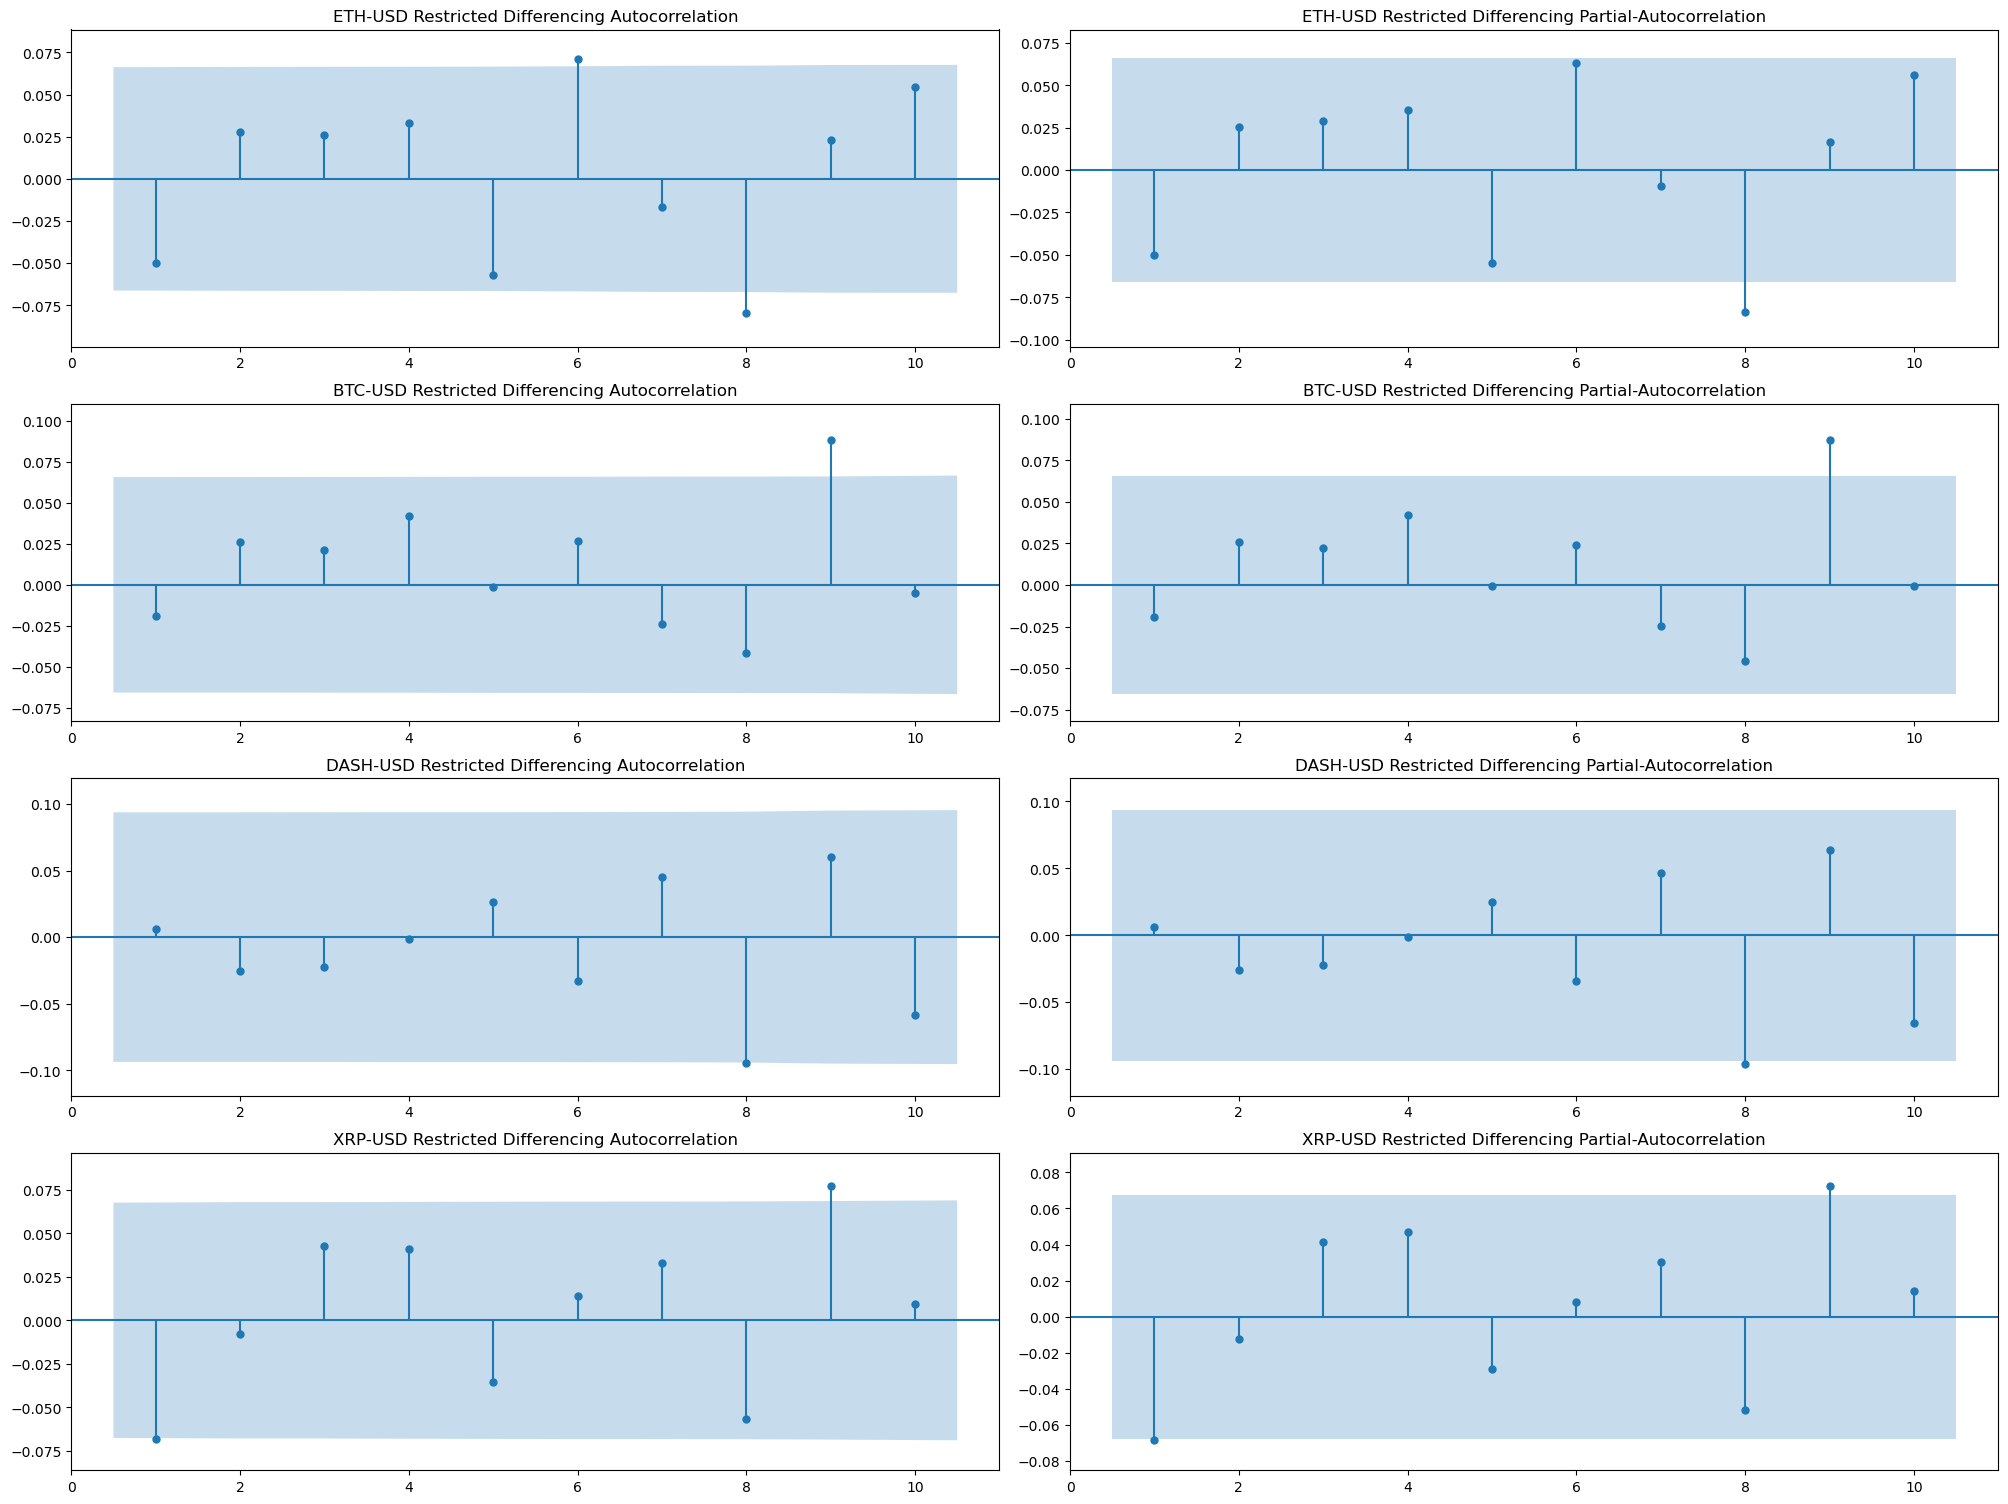

<Figure size 640x480 with 0 Axes>

In [34]:
correlograms(
    trainCryptoDiffDict,
    "Diff",
    cryptoList,
    titleAuto = "Restricted Differencing Autocorrelation",
    titlePartial = "Restricted Differencing Partial-Autocorrelation", 
    zeroAuto = False, yLimsAuto = True,
    zeroPar = False, yLimsPar = True
)

Osserviamo forte correlazione (effetto clustering) e quindi potremmo procedere a modellarli con dei processi GARCH.

##### 3_1_4. Analisi Normalità
Per l'analisi di normalità eseguiamo i seguenti test:
* Shapiro-Wilk
* Kolmogorov-Smirnov

Nel test di Shapiro-Wilk abbiamo:
* $H_0$: I dati seguono una distribuzione normale
* $H_1$: I dati NON seguono una distribuzione normale

Nel test di Kolmogorov-Smirnov abbiamo:
* $H_0$: I dati seguono la distribuzione specificata
* $H_1$: I dati NON seguono la distribuzione specificata

Nel nostro caso vogliamo:
* Shapiro-Wilk, **Accettare**
* Kolmogorov-Smirnov, **Accettare**

In [35]:
shapiro_wilk(trainCryptoDiffDict, "Diff", cryptoList)
kolmogorov_smirnov(trainCryptoDiffDict, "Diff", cryptoList)

                            Shapiro-Wilk                            
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃          StatValue ┃                 pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │ 0.9502420425415039 │ 1.3270286513620812e-16 │ Reject  │
│ BTC-USD  │ 0.9572618007659912 │  1.919576134737323e-15 │ Reject  │
│ DASH-USD │  0.939193844795227 │ 2.2313227654446877e-12 │ Reject  │
│ XRP-USD  │ 0.8953757286071777 │ 1.7658039207309898e-23 │ Reject  │
└──────────┴────────────────────┴────────────────────────┴─────────┘

                          Kolmogorov-Smirnov                          
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃           StatValue ┃                  pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │ 0.47223125234355756 │ 1.3485745072511574e-179 │ Reject  │
│ BTC-USD  │  0.4785933494051804 │ 3.9304122976977064e-188 │ Reject  │
│ DASH-USD │  0.4741664051569694 │   9.750037391596386e-91 │ Reject  │
│ XRP-USD  │ 0.46522174716623627 │ 1.8352320088248526e-167 │ Reject  │
└──────────┴─────────────────────┴─────────────────────────┴─────────┘

## 5. Quadratic autocorrelation

In [36]:
ljung_box_test(trainCryptoDiffDict, "QuadDiff", cryptoList)

                             Ljung-Box                              
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃          StatValue ┃                 pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │ 107.45662340504884 │ 1.7362744278257656e-18 │ Reject  │
│ BTC-USD  │ 28.435878927917237 │  0.0015366636984585028 │ Reject  │
│ DASH-USD │ 20.296369471575147 │   0.026570915198950266 │ Reject  │
│ XRP-USD  │ 124.35893071112875 │  6.585066550321394e-22 │ Reject  │
└──────────┴────────────────────┴────────────────────────┴─────────┘

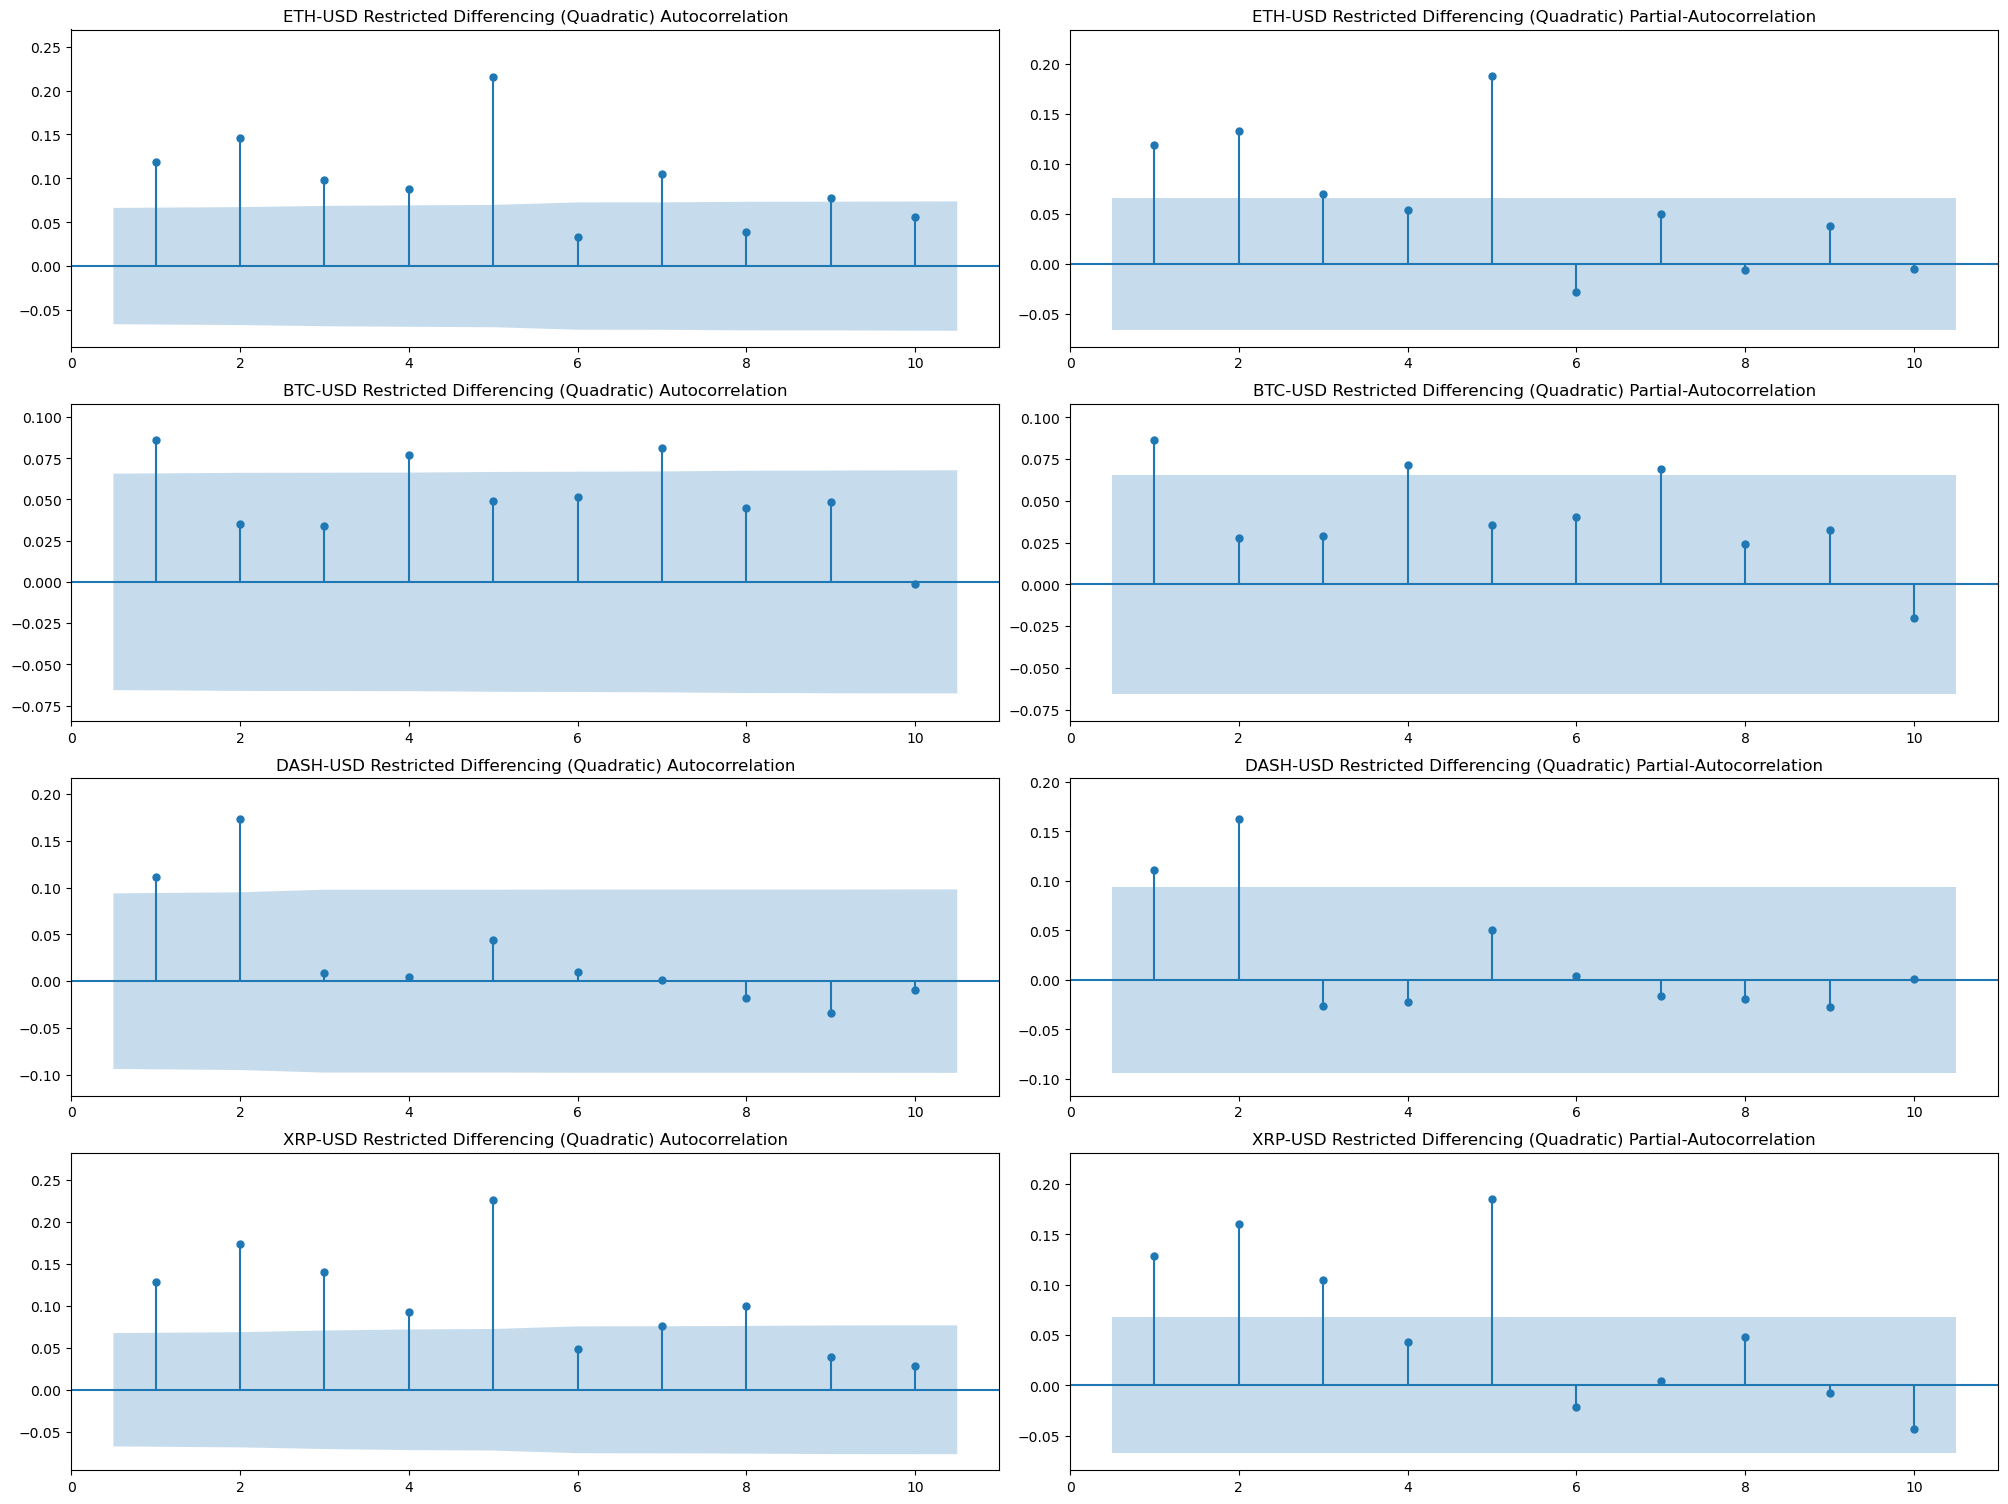

<Figure size 640x480 with 0 Axes>

In [37]:
correlograms(
    trainCryptoDiffDict, 
    "QuadDiff", 
    cryptoList,
    titleAuto = "Restricted Differencing (Quadratic) Autocorrelation",
    titlePartial = "Restricted Differencing (Quadratic) Partial-Autocorrelation",
    zeroAuto = False, zeroPar = False,
    yLimsAuto = True, yLimsPar = True
)

In practice, only rather rich ARCH parameterizations are able to
ﬁt ﬁnancial series adequately
However, largely parameterized models can be unstable in
forecasting and a hard to estimate
In order to overcome the shortcomings of the ARCH, Tim
Bollerslev proposed a generalisation of the ARCH model called
GARCH (Bollerslev, 1986)
The model allows to ﬁt ﬁnancial returns adequately while keeping
the number of parameters small
In practice, the GARCH model is one of the most successfully
employed volatility models

(da pag 63 a 110 circa)

In [71]:
#TODO prima di simulare analizzare i residui (capire la bontà del modello stimato) osservando:
#  stazionarietà(fondamentale -> se non c'è stazionarietà non vale nulla),
#  correlazione(non devono essere correlati -> ci sarebbe informazione nei dati che il modello non riesce ad estrarre -> non è un buon modello),
#  se non sono autocorrelati -> vediamo se sono eterosschedastici (se sono molto eteroschedastici non ci piace molto -> dovremmo trasformare sui dati di partenza -> in teoria già lo abbiamo fatto),
#  problema-> come sono distribuiti? ci piacerebbe che fossero normali.
#  NB:] modelli arch e Garch se (..?..) restituistcono dati che hanno non necessariamente distribuzione normale (code più spesse) ma il contrario è più difficile ottenere una normale (vengono student o logistica...)
#  a quel punto ci sono varie alternative:
#       - analisi parametrica dei residui 
#           (grafico kullen friger -> in che disposizione all'interno del piano si collocano il quadrato della skewness e kurtosi)
#           a quel punto uno prende i parametri della distribuzione e cerca di fare una stima sui residui (?)
#           dopo che vengono costruite queste traiettorie potremmo costruire le bande di predizione o altre cose..
#       - approccio non parametrico: tecniche di bootstrap bypassando la stima della distribuzione dei residui e costruiamo direttamente le bande di predizione

# TECNICA del bootstrap:
# bande di confidenza:
# io ho un dataset, se è normale allora moltiplico il quantile per la deviazione standard e sommo (accavallandosi sulla media) e ottendgo una banda di confidenza standard
# se non è normale o stimo la distribuzione etc etc oppure uso bootstrap. 
#   come?
#   - prendo i miei dati, faccio es:1000 campionamenti dei dati e mi calcolo quantili empirici es:20/80% e lo ripeto per tutti i campioni e scelgo tra mediana (tiro fuori gli outliers) e media (tengo outliers) dei quantili
#   questa tecnica sembra funzionare bene:
#   VANTAGGIO: bypasso la stima della distribuzione dei residui, 
#   SVANTAGGIO: ho rinunciato a capire la distribuzione dei residui 
#               -> perdo delle informazioni sul meccanismo che genera la time series... 
#               ad esempio alcune di volte vedo che eventi rari non sono poi così rari... 
#               in termini di mercato ad esempio rendimenti straordinari in positivo o negativo possono capitare non tanto difficilmente -> legato alla skewness e analizzo che a parità di valore assoluto c'è una avversione al rischio e quindi si tende a fuggire dal mercato, calo dei prezzi -> i rendimenti negativi sono più probabili di quelli positivi)
#               caso reale: vendita automatica con meccanismi di stop-loss 
#               -> caso delle torri gemelle -> indice daws jhons scende vertiginosamente in maniera automatizzata
residualsDict : {str, pd.DataFrame} = {}
for crypto in cryptoList :
    tempCryptoDiff = trainCryptoDiffDict[crypto]["Diff"].copy() #TODO rimettere df tagliato
    model = arch_model(tempCryptoDiff)
    fittedModel = model.fit(disp='off')  # Setting disp to 'off' to suppress convergence messages
    console.print(crypto + "\n" + str(fittedModel.summary()))
    residualsDict[crypto] = pd.DataFrame(data = {"Resid" : fittedModel.resid})

ETH-USD
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   Diff   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2214.67
Distribution:                  Normal   AIC:                          -4421.35
Method:            Maximum Likelihood   BIC:                          -4402.25
                                        No. Observations:                  875
Date:                Tue, Dec 05 2023   Df Residuals:                      874
Time:                        12:22:49   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         5.1548e-04  5.980e-04      0.862      0.389 [-6.566e-04,1.688e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      8.7622e-06  3.227e-11  2.715e+05      0.000 [8.762e-06,8.762e-06]
alpha[1]       0.0999  3.855e-02      2.592  9.552e-03   [2.435e-02,  0.175]
beta[1]        0.8801  3.175e-02     27.722 3.824e-169     [  0.818,  0.942]
============================================================================

Covariance estimator: robust

BTC-USD
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   Diff   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2457.09
Distribution:                  Normal   AIC:                          -4906.17
Method:            Maximum Likelihood   BIC:                          -4887.00
                                        No. Observations:                  891
Date:                Tue, Dec 05 2023   Df Residuals:                      890
Time:                        12:22:49   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.5056e-04  4.904e-04      0.307      0.759 [-8.106e-04,1.112e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      5.2742e-06  1.534e-13  3.437e+07      0.000 [5.274e-06,5.274e-06]
alpha[1]       0.0500  8.641e-04     57.854      0.000 [4.830e-02,5.169e-02]
beta[1]        0.9298  5.429e-03    171.285      0.000     [  0.919,  0.940]
============================================================================

Covariance estimator: robust

DASH-USD
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   Diff   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                1111.64
Distribution:                  Normal   AIC:                          -2215.28
Method:            Maximum Likelihood   BIC:                          -2198.96
                                        No. Observations:                  437
Date:                Tue, Dec 05 2023   Df Residuals:                      436
Time:                        12:22:49   Df Model:                            1
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -6.4232e-04  8.411e-04     -0.764      0.445 [-2.291e-03,1.006e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      5.7952e-05  1.155e-05      5.017  5.237e-07 [3.531e-05,8.059e-05]
alpha[1]       0.1076  6.875e-02      1.565      0.117  [-2.712e-02,  0.242]
beta[1]        0.7379  7.224e-02     10.215  1.697e-24     [  0.596,  0.880]
============================================================================

Covariance estimator: robust

XRP-USD
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   Diff   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2047.80
Distribution:                  Normal   AIC:                          -4087.60
Method:            Maximum Likelihood   BIC:                          -4068.65
                                        No. Observations:                  842
Date:                Tue, Dec 05 2023   Df Residuals:                      841
Time:                        12:22:49   Df Model:                            1
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -4.6731e-04  6.177e-04     -0.757      0.449 [-1.678e-03,7.433e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.5062e-05  1.386e-11  1.087e+06      0.000 [1.506e-05,1.506e-05]
alpha[1]       0.1002  4.460e-02      2.247  2.463e-02   [1.281e-02,  0.188]
beta[1]        0.8785  3.225e-02     27.244 1.942e-163     [  0.815,  0.942]
============================================================================

Covariance estimator: robust

In [64]:
# STAZIONARIETÀ
kpss_test(residualsDict, "Resid", cryptoList)
adf_test(residualsDict, "Resid", cryptoList)

# ETEROSCHEDASTICITÀ
breusch_pagan_test(residualsDict, "Resid", cryptoList)
white_test(residualsDict, "Resid", cryptoList)

# AUTOCORRELAZIONE
ljung_box_test(residualsDict, "Resid", cryptoList)

                        KPSS                         
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃           StatValue ┃ pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │ 0.30402339982507376 │    0.1 │ Accept  │
│ BTC-USD  │ 0.26793706713609056 │    0.1 │ Accept  │
│ DASH-USD │  0.1444848743287086 │    0.1 │ Accept  │
│ XRP-USD  │ 0.10857489114721607 │    0.1 │ Accept  │
└──────────┴─────────────────────┴────────┴─────────┘

                                ADF                                 
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃           StatValue ┃                pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │ -31.463043189797844 │                   0.0 │ Reject  │
│ BTC-USD  │  -30.48376558066174 │                   0.0 │ Reject  │
│ DASH-USD │ -15.051422863190425 │ 9.281783031353076e-28 │ Reject  │
│ XRP-USD  │ -31.024464015415525 │                   0.0 │ Reject  │
└──────────┴─────────────────────┴───────────────────────┴─────────┘

                           Breusch-Pagan                           
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃          StatValue ┃                pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │  25.05566267671039 │ 6.737702332421678e-07 │ Reject  │
│ BTC-USD  │ 25.845017636834086 │ 4.511427906820313e-07 │ Reject  │
│ DASH-USD │ 2.4951685643659363 │   0.11492299248949614 │ Accept  │
│ XRP-USD  │  34.83443112648268 │ 5.204886672229033e-09 │ Reject  │
└──────────┴────────────────────┴───────────────────────┴─────────┘

                               White                                
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃          StatValue ┃                 pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │ 13.165166097743306 │   2.32843202022156e-06 │ Reject  │
│ BTC-USD  │ 13.223014533193261 │  2.193663541133534e-06 │ Reject  │
│ DASH-USD │  3.299977334208391 │   0.037811687468737934 │ Reject  │
│ XRP-USD  │  23.00017453495101 │ 1.8852487009909468e-10 │ Reject  │
└──────────┴────────────────────┴────────────────────────┴─────────┘

                            Ljung-Box                             
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃          StatValue ┃               pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │ 20.744396382469045 │ 0.022948121087501668 │ Reject  │
│ BTC-USD  │ 12.632829754955269 │  0.24493117060835012 │ Accept  │
│ DASH-USD │   9.34822022595346 │  0.49940562393741106 │ Accept  │
│ XRP-USD  │  16.88301121552119 │  0.07699305871115278 │ Accept  │
└──────────┴────────────────────┴──────────────────────┴─────────┘

<Figure size 1600x900 with 0 Axes>

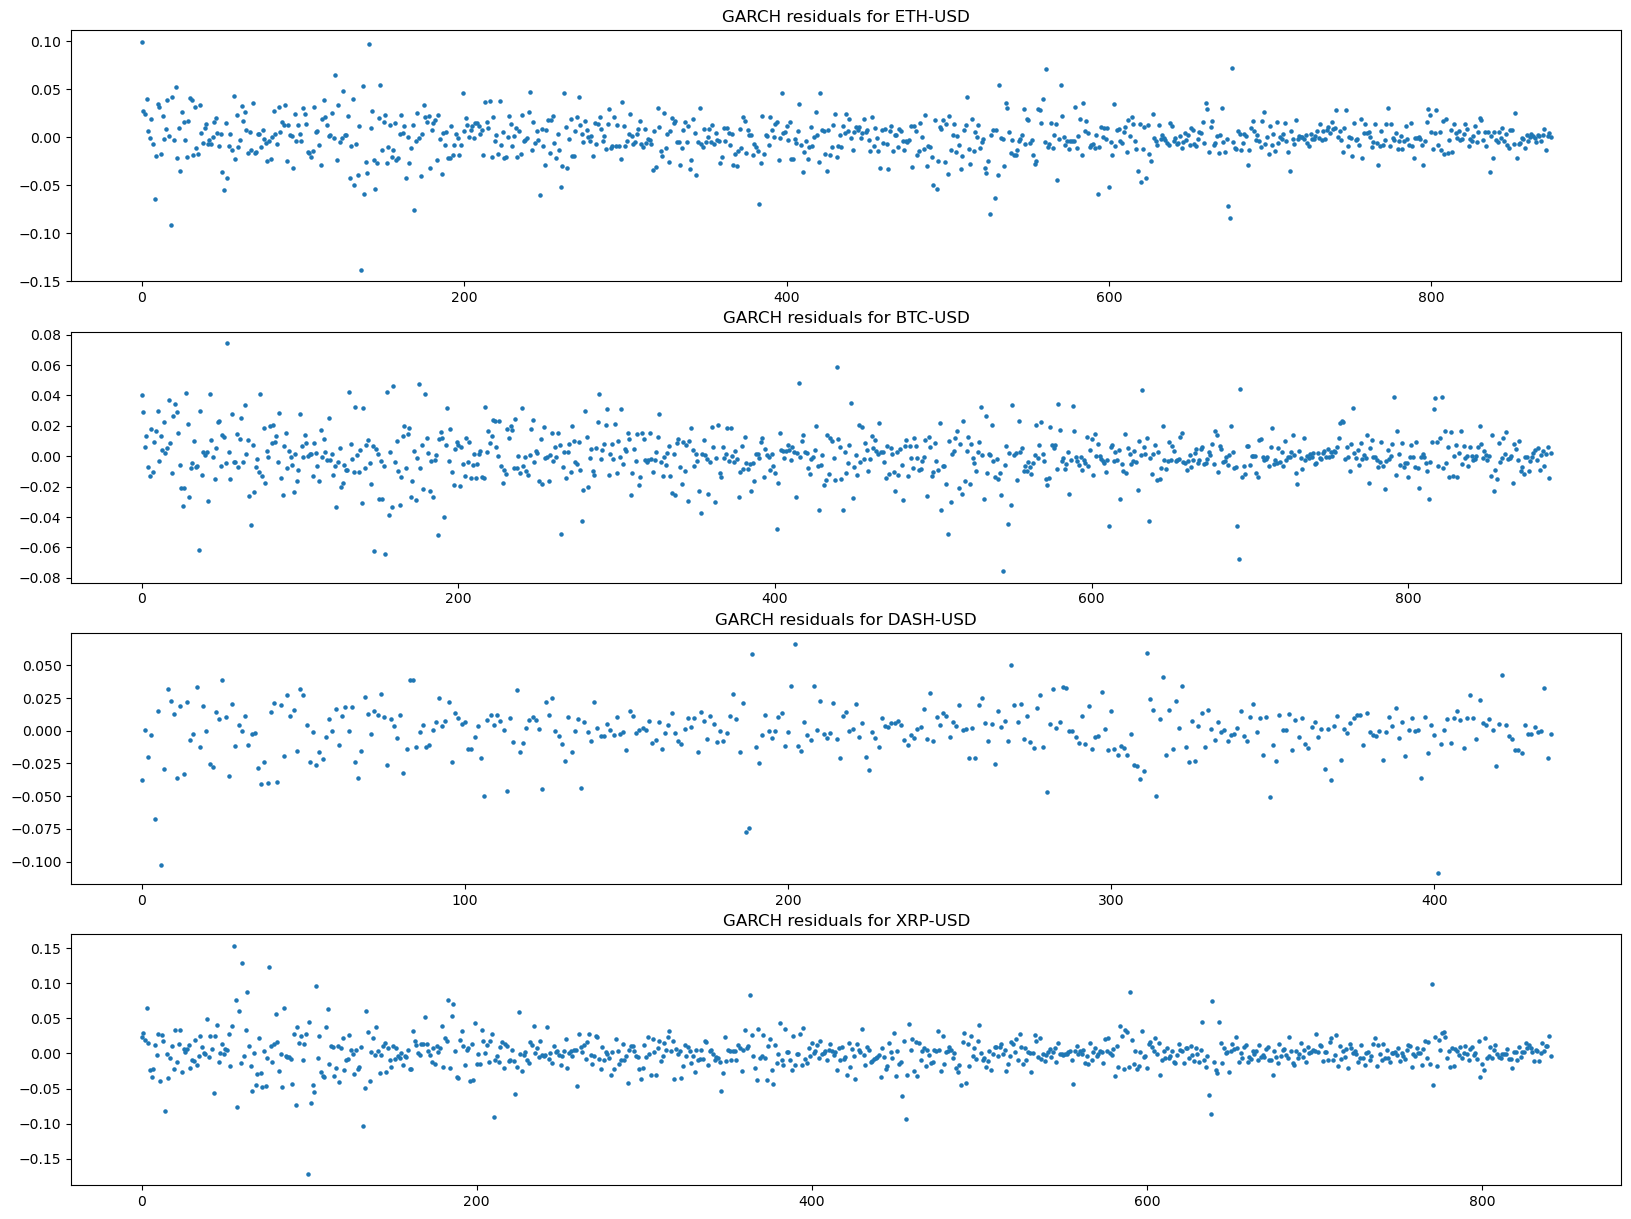

In [86]:
plt.figure(figsize= (16,9))
fig, axs = plt.subplots(nrows=len(cryptoList), figsize=(20, 15))
i = 0
for crypto in cryptoList:
    axs[i].scatter(x = np.arange(0, residualsDict[crypto].shape[0]), y = residualsDict[crypto]["Resid"], sizes = [5])
    axs[i].set_title("GARCH residuals for " + crypto)
    i += 1

In [65]:
#APPLICO BOOTSTRAP:
# faccio es:1000 campionamenti dei dati e mi calcolo quantili empirici es:20/80%
# lo ripeto per tutti i campioni 
# scelgo tra mediana (tiro fuori gli outliers) e media (tengo outliers) dei quantili
NUM_SAMPLES = 1000
np.random.seed(NP_RANDOM_SEED)
quantileTable = buildTable("Quantile of Bootstrap Samples", ["Crypto", "25q Mean", "25q Median", "75q Mean", "75q Median"], ["left", "right", "right", "right", "right"])
sampleQuantileDict : {str,tuple} = {}
for crypto in cryptoList:
    tempCryptoDiff = trainCryptoDiffDict[crypto]["Diff"].copy()
    quantList_25 = []
    quantList_75 = []
    for _ in range(NUM_SAMPLES):
        # Resampling with replacement
        #TODO mettere i residui o i dati di training?
        bootstrapSample = np.random.choice(a=tempCryptoDiff, size=int(residualsDict[crypto].shape[0]*2/3), replace=True)
        # calcolo quantili 25/75%
        quantList_25.append(np.quantile(a=bootstrapSample, q=0.25))
        quantList_75.append(np.quantile(a=bootstrapSample, q=0.75))
    # Calculating statistic of interest (e.g., mean, median, etc.)
    quantMean_25 = np.mean(quantList_25)
    quantMean_75 = np.mean(quantList_75)
    quantMedian_25 = np.median(quantList_25)
    quantMedian_75 = np.median(quantList_75)
    sampleQuantileDict[crypto] = (quantMean_25, quantMedian_25, quantMean_75, quantMedian_75) 
    quantileTable.add_row(crypto, str(quantMean_25), str(quantMedian_25), str(quantMean_75), str(quantMedian_75))

console.print(quantileTable)

                                      Quantile of Bootstrap Samples                                       
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Crypto   ┃              25q Mean ┃            25q Median ┃             75q Mean ┃           75q Median ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ ETH-USD  │ -0.009297171657420344 │ -0.009159962556701595 │  0.01170597682241532 │ 0.011945746118586342 │
│ BTC-USD  │ -0.007243443851918247 │ -0.007121437456616642 │ 0.007962778164287372 │ 0.007979493274088867 │
│ DASH-USD │ -0.010348265722397188 │  -0.01072714290095167 │ 0.009899726037568588 │  0.01001026509765135 │
│ XRP-USD  │ -0.010397792423661014 │ -0.010274399622739017 │  0.01041087406065753 │ 0.010509651904937078 │
└──────────┴───────────────────────┴───────────────────────┴──────────────────────┴──────────────────────┘

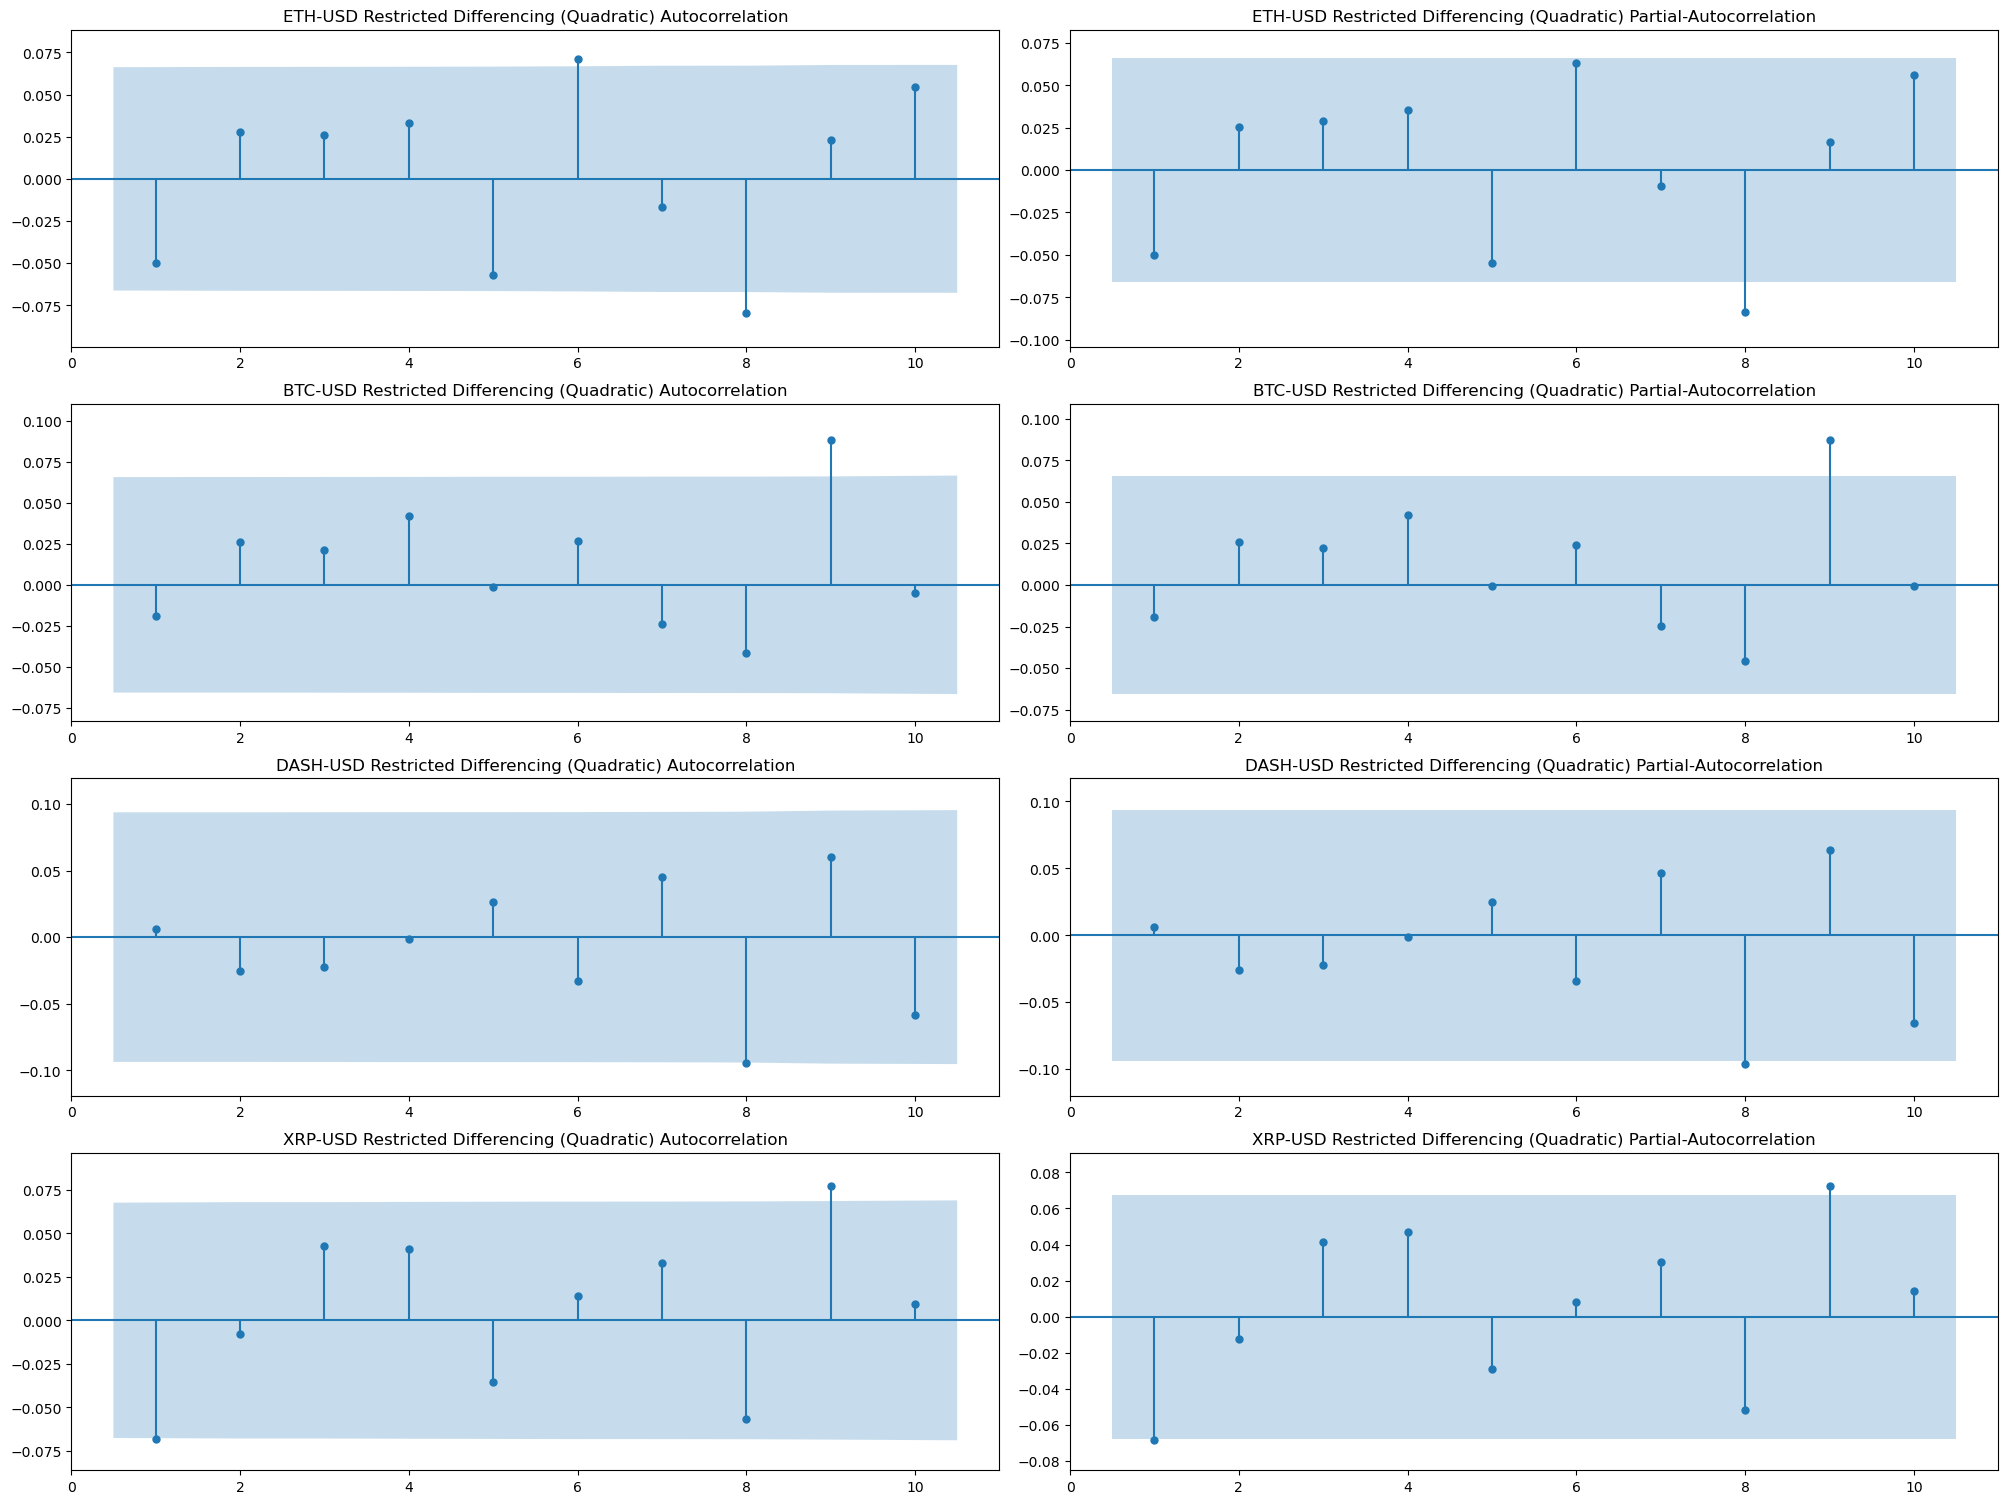

<Figure size 640x480 with 0 Axes>

In [67]:
correlograms(
    residualsDict, 
    "Resid", 
    cryptoList,
    titleAuto = "Restricted Differencing (Quadratic) Autocorrelation",
    titlePartial = "Restricted Differencing (Quadratic) Partial-Autocorrelation",
    zeroAuto = False, zeroPar = False,
    yLimsAuto = True, yLimsPar = True
)

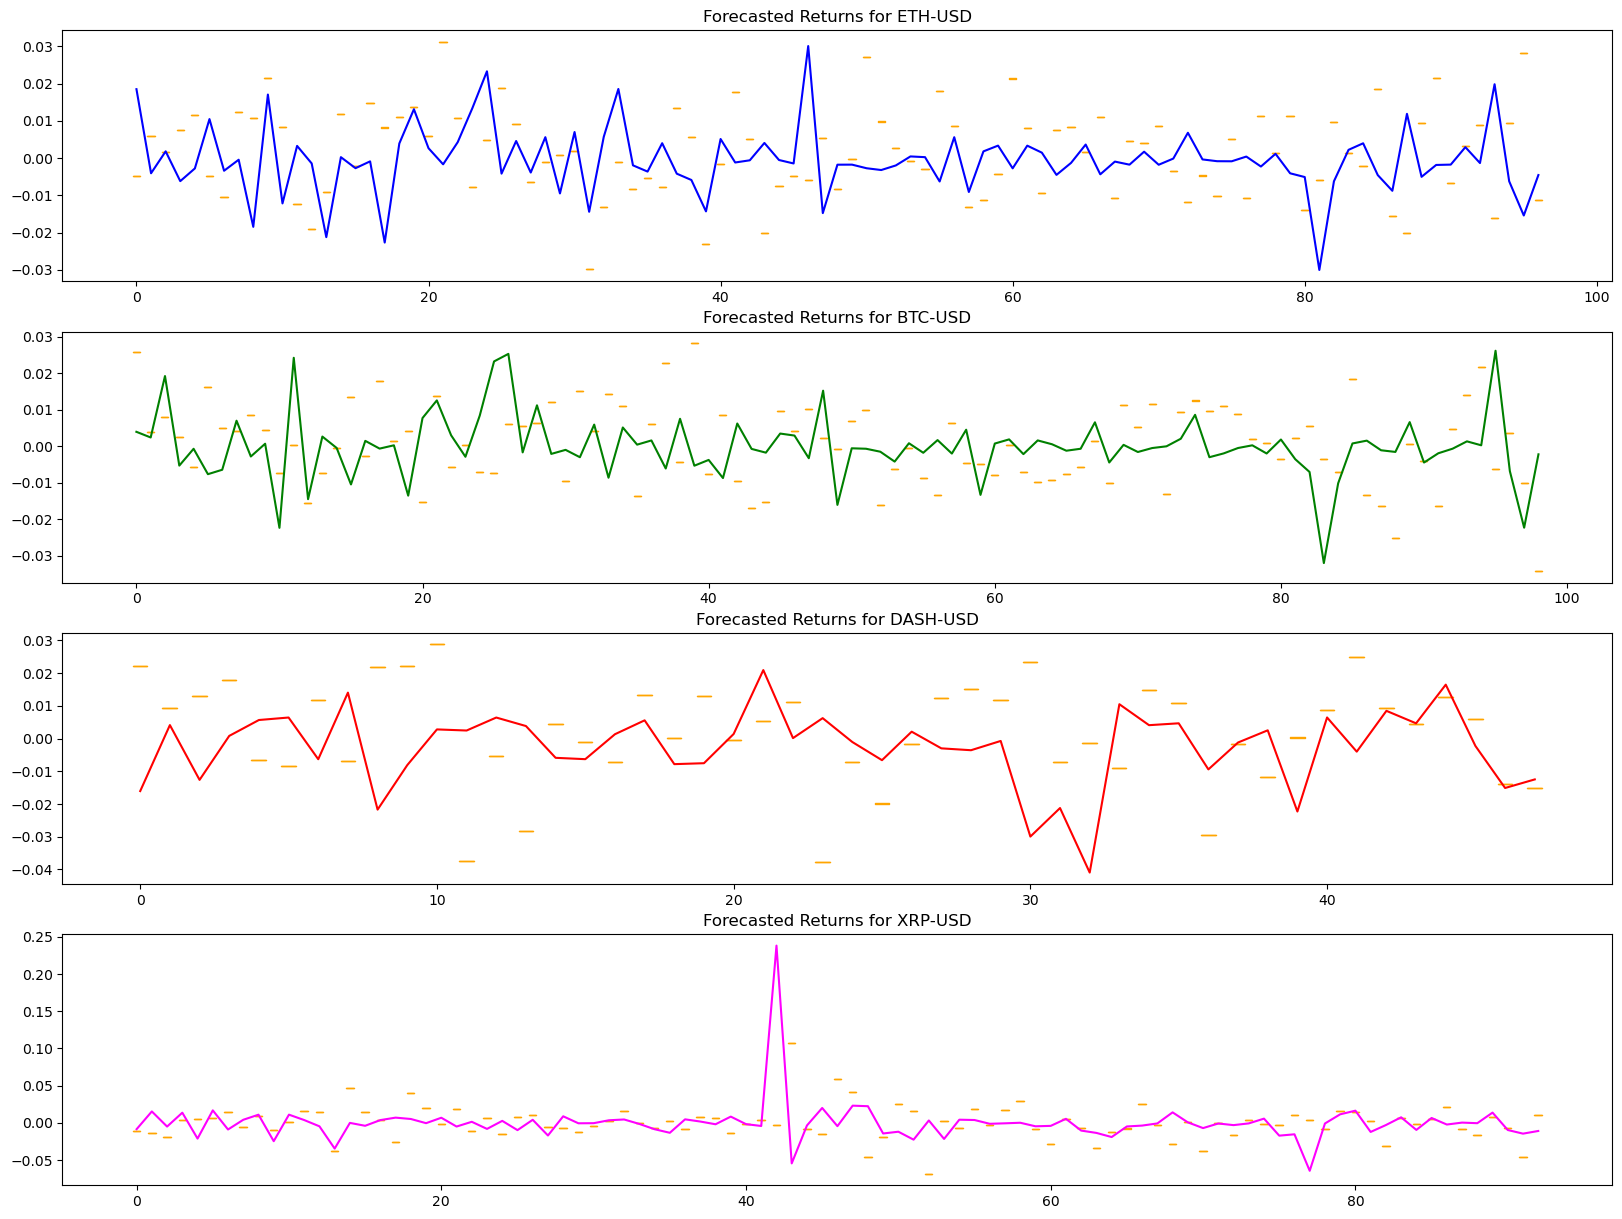

<Figure size 640x480 with 0 Axes>

In [68]:
NUM_SAMPLES = 1000
fig, axs = plt.subplots(nrows = len(cryptoList), ncols = 1, figsize=(20,15))
axsIndex = 0
np.random.seed(NP_RANDOM_SEED)

for crypto in cryptoList :
    N_TESTS = testCryptoDiffDict[crypto]["Diff"].shape[0]
    tempCryptoDiff = trainCryptoDiffDict[crypto]["Diff"].copy()
    
    i = 0
    for testNum in range(N_TESTS):
        # Create a GARCH model and fit it to the data
        garchModel = arch_model(tempCryptoDiff)
        fittedModel = garchModel.fit(disp='off')  # Setting disp to 'off' to suppress convergence messages
        # Forecast the next period's conditional variance
        garchForecast = fittedModel.forecast(horizon=1)
        # Extract the forecasted conditional variance
        forecastedVariance = garchForecast.variance.values[-1, :][0]
        #forecastedMean = garchForecast.mean.values[-1, :][0]

        armaModel = ARIMA(tempCryptoDiff).fit()
        forecastedMean = armaModel.get_forecast(1).predicted_mean
        # print(forecastedMean)

#TODO -> SIMULARE MOLTISSIME VOLTE E POI FARE LA MEDIA: 
        #su ogni tempo generare quantili empirici e arrivare alle BANDE DI PREDIZIONE
        quantList_25 = []
        quantList_75 = []
        for _ in range(NUM_SAMPLES):
            #TODO mettere i residui o i dati di training
            bootstrapSample = np.random.choice(a = residualsDict[crypto]["Resid"], size = int(residualsDict[crypto].shape[0]*2/3), replace=True)
            quantList_25.append(np.quantile(a = bootstrapSample, q = 0.25))
            quantList_75.append(np.quantile(a = bootstrapSample, q = 0.75))
        
        prediction = np.random.normal(loc = forecastedMean, scale = np.sqrt(forecastedVariance))

        quantMean_25 = np.mean(quantList_25)
        quantMean_75 = np.mean(quantList_75)

        # plt.scatter(x, y_true, label='Dati reali', color='blue', alpha=0.5)
        # plt.plot(i, y_pred, label='revisioni', color='orange')
        x_array = np.arange(i - 0.25, i + 0.25, 0.01)
        y1_array = np.full(len(x_array), prediction - quantMean_25 * np.sqrt(forecastedVariance)) 
        y2_array = np.full(len(x_array), prediction + quantMean_75 * np.sqrt(forecastedVariance)) 
        axs[axsIndex].fill_between(x_array, y1_array, y2_array, color='orange', alpha=1, label='Bande di predizione')

        # Update your time series with the simulated return for the next period
        tempCryptoDiff.loc[tempCryptoDiff.shape[0]] = testCryptoDiffDict[crypto]["Diff"].iloc[i]

        i += 1

    axs[axsIndex].plot(testCryptoDiffDict[crypto]["Diff"], color = colors[axsIndex])
    #axs[axsIndex].plot(np.arange(0, N_TESTS, 1), predictions, color = "black")
    axs[axsIndex].set_title("Forecasted Returns for " + crypto)
    axsIndex += 1

plt.show()
plt.clf()

#TODO plot the actual variance
# plt.plot(testCryptoDiffDict["ETH-USD"]["QuadDiff"])
# plt.plot(np.arange(0, N_TESTS, 1), predictions)
# plt.show()



In [69]:
#TODO ETHEREUM rigetta lijungbox -> PROVARE: ARMA sui rendimenti / GARCH sui residui del modello ARMA
# forse scopriamo che se funzionasse arma allora i rendimenti sono predicibili e quindi il mercato per ETH-USD non è efficiente
# NB:] l'idea del mercato efficiente è che i rendimenti non siano predicibili ma la loro volatilità sì (è più probabile che a momenti di alta volatilità corrispondano più probabilmente momenti di alta volatilità)
